In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# target 준비

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.losses import CTC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
from dotenv import load_dotenv
import os
# import mysql.connector

In [ ]:
env_path = "C:/Users/eunhy/OneDrive/문서/new/f.env"
load_dotenv(dotenv_path=env_path)

def get_connection():
    conn = mysql.connector.connect(
        host=os.getenv("db_host"),
        database=os.getenv("db_database"),
        user=os.getenv("db_username"),
        password=os.getenv("db_password")
    )
    return conn

def is_invalid(value):
    return pd.isna(value) or value == ""

# ####################################### #
# get_file_lst
# 파일 경로와 목록 정보를 조회
# ####################################### #
def get_file_lst(assess_type, question_cd, question_no=None, order_num=None):
    conn = None
    cursor = None
    try:
        conn = get_connection()
        cursor = conn.cursor()

        sql = ""
        sql +=  "select lst.ORDER_NUM, lst.ASSESS_TYPE, lst.QUESTION_CD, lst.QUESTION_NO, lst.QUESTION_MINOR_NO "
        sql +=  "   , concat(lst.MAIN_PATH,'/',lst.SUB_PATH) as PATH, lst.FILE_NAME, lst.DURATION, lst.RATE "
        sql +=  "	, ref.SCORE, alc.SCORE_ALLOCATION as alc_score, alc.note "
        sql +=  "from assess_file_lst lst "
        sql +=  "	inner join assess_lst alst "
        sql +=  "		on lst.PATIENT_ID = alst.PATIENT_ID "
        sql +=  "		and lst.ORDER_NUM = alst.ORDER_NUM "
        sql +=  "		and alst.EXCLUDED = '0' "
        sql +=  "	inner join assess_score_reference ref "
        sql +=  "		on lst.PATIENT_ID = ref.PATIENT_ID "
        sql +=  "		and lst.ORDER_NUM = ref.ORDER_NUM "
        sql +=  "		and lst.ASSESS_TYPE = ref.ASSESS_TYPE "
        sql +=  "		and lst.QUESTION_CD = ref.QUESTION_CD "
        sql +=  "		and lst.QUESTION_NO = ref.QUESTION_NO "
        sql +=  "       and ref.USE_YN = 'Y' "
        sql +=  "	left outer join assess_score_allocation alc "
        sql +=  "		on lst.ASSESS_TYPE = alc.ASSESS_TYPE "
        sql +=  "		and lst.QUESTION_CD = alc.QUESTION_CD "
        sql +=  "		and lst.QUESTION_NO = alc.QUESTION_NO "
        sql += f"where lst.ASSESS_TYPE = '{assess_type}' "
        sql += f"and lst.QUESTION_CD = '{question_cd}' "
        if question_no:
            sql += f"and lst.QUESTION_NO = {question_no} "
        if order_num:
            sql += f"and lst.ORDER_NUM = {order_num} "
        sql +=  "and lst.USE_YN = 'Y' "

        cursor.execute(sql)
        rows = cursor.fetchall()
        ret_df = pd.DataFrame(rows, columns=['ORDER_NUM', 'ASSESS_TYPE', 'QUESTION_CD', 'QUESTION_NO', 'QUESTION_MINOR_NO', 'Path','File Name','Duration', 'Rate', 'Score(Refer)', 'Score(Alloc)', 'Note' ])

        msg = f'{len(ret_df)}건의 데이터가 조회되었습니다.'
        return msg, ret_df

    except Exception as e:
        return f"오류 발생: {str(e)}", None

    finally:
        if cursor:
            cursor.close()
        if conn:
            conn.close()

In [ ]:
def audio_preprocess(wav, sr=16000, n_mels=80):
  """input: 음성데이터 경로(str)
     output: Mel_spectrogram 변환데이터(np.array), Mel_spectrogram 길이(int)"""
  ori_y1, sr1 = librosa.load(wav, sr=sr)
  # mel_spec1 = librosa.feature.melspectrogram(y=ori_y1, sr=sr1, n_mels=n_mels, fmax=4200)
  mel_spec1 = librosa.feature.melspectrogram(y=ori_y1, sr=sr1, n_mels=n_mels)
  mel_db1 = librosa.power_to_db(mel_spec1, ref=np.max)
  # mel_db1 = mel_db1[:100,:]
  return mel_db1, mel_db1.shape[1]

In [ ]:
# wav 데이터 padding
def wav_padding(wav, wav_max_len=312):
  """input: wav 데이터(np.array)
     output: padding된 wav 데이터(np.arrray)"""
  pad_width = wav_max_len - wav.shape[1]  # 얼마나 채워야 하는지
  if pad_width > 0:
      # 오른쪽(열 끝)에 0을 채움: ((행 시작, 행 끝), (열 시작, 열 끝))
      padded = np.pad(wav, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
  elif pad_width == 0:
      padded = wav  # 이미 가장 김
  elif pad_width < 0:
      padded = wav[:, :wav_max_len]
  return padded

In [ ]:
def x_data_preprocess(x, sr=16000, n_mels=80):
  temp_wav_list = []
  temp_wav_length_list = []
  if isinstance(x,(list,np.ndarray)):
    print("x_data_preprocess for문 시작")
    for path in tqdm(x):
      temp_wav_data, temp_wav_length = audio_preprocess(path,sr,n_mels)
      temp_pad_wav_data = wav_padding(temp_wav_data)
      temp_wav_list.append(temp_pad_wav_data)
      temp_wav_length_list.append(temp_wav_length)

    temp_x_padded_data = np.array(temp_wav_list)
    temp_x_data = np.transpose(temp_x_padded_data, (0, 2, 1))
    temp_x_data_length = np.array(temp_wav_length_list)

    return temp_x_data, temp_x_data_length
  elif isinstance(x,str):
    temp_wav_data, temp_x_data_length = audio_preprocess(x,sr,n_mels)
    temp_x_data = wav_padding(temp_wav_data)
    return temp_x_data, temp_x_data_length

In [ ]:
class Seq_Util():
  """
  sub_x_data에 들어갈 문항 목표단어의 자모 시퀀스를 준비하기 위한 Class

  # 변수
  jamo_to_index: dict{자모:인덱스}
  index_to_jamo: dict{인덱스:자모}
  vocab_size: 자모개수

  # 함수
  decompose_hangul: 자모 분해 함수
  char_to_index: 자모 -> idx
  seq_padding: 시퀀스 패딩
  text_to_seq: 단어 -> 자모 시퀀스
  """
  def __init__(self):
    # 자모 리스트 정의
    self.CHOSUNG_LIST = ['ㄱ','ㄲ','ㄴ','ㄷ','ㄸ','ㄹ','ㅁ','ㅂ','ㅃ','ㅅ','ㅆ',
                    'ㅇ','ㅈ','ㅉ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ']
    self.JUNGSUNG_LIST = ['ㅏ','ㅐ','ㅑ','ㅒ','ㅓ','ㅔ','ㅕ','ㅖ','ㅗ','ㅘ','ㅙ',
                    'ㅚ','ㅛ','ㅜ','ㅝ','ㅞ','ㅟ','ㅠ','ㅡ','ㅢ','ㅣ']
    self.JONGSUNG_LIST = ['','ㄱ','ㄲ','ㄳ','ㄴ','ㄵ','ㄶ','ㄷ','ㄹ','ㄺ','ㄻ',
                    'ㄼ','ㄽ','ㄾ','ㄿ','ㅀ','ㅁ','ㅂ','ㅄ','ㅅ','ㅆ',
                    'ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ']
    self.RESERVED = ["<pad>", "<sos>", "<eos>", " "]  # <pad> == <blank>

    # 자모 인덱스 테이블 만들기
    self.ALL_JAMOS = sorted(set(self.CHOSUNG_LIST + self.JUNGSUNG_LIST + self.JONGSUNG_LIST))
    self.ALL_JAMOS.remove('')  # 종성의 공백 제거

    self.ALL_JAMOS = self.RESERVED + self.ALL_JAMOS

    # 자모 사전 만들기
    self.jamo_to_index = {j: i for i, j in enumerate(self.ALL_JAMOS)}
    self.index_to_jamo = {i: j for j, i in self.jamo_to_index.items()}

    self.vocab_size = len(self.jamo_to_index)


  def decompose_hangul(self, text):
    """input:단어(str)
       output:자모 시퀀스(list) """
    result = ["<sos>"]
    for char in text:
      if '가' <= char <= '힣':
        code = ord(char) - ord('가')
        cho = self.CHOSUNG_LIST[code // (21*28)]
        jung = self.JUNGSUNG_LIST[(code % (21*28)) // 28]
        jong = self.JONGSUNG_LIST[code % 28]
        result.extend([cho, jung])
        if jong != '':
            result.append(jong)
      else:
        result.append(char)
    result.append("<eos>")
    return result


  def char_to_index(self, text):
    """input: 자모 시퀀스(list)
       output: 인덱스 시퀀스(list)"""
    text = text[1:] if text[0] == " " else text
    text = text[:-1] if text[-1] == " " else text
    idx_seq = [self.jamo_to_index[j] for j in text if j in self.jamo_to_index]
    return idx_seq


  def seq_padding(self, seq, seq_max_len=12):
    """input: 인덱스 시퀀스(list)
       output: 패딩된 인덱스 시퀀스(list)"""
    pad_width = seq_max_len - len(seq)  # 얼마나 채워야 하는지
    if pad_width > 0:
      # 오른쪽(열 끝)에 0을 채움: ((행 시작, 행 끝), (열 시작, 열 끝))
      for _ in range(pad_width):
        seq.append(0)
    return seq


  def text_to_seq(self, text):
    """input: 단어(str)
       output: 패딩된 인덱스 시퀀스(list)"""
    temp_seq_list = []
    temp_seq_length_list = []

    if isinstance(text,(list,np.ndarray)):
      print("text_to_seq for문 시작")
      for seq in tqdm(text):
        jamo= self.decompose_hangul(seq)
        length = len(jamo)
        idx_seq = self.char_to_index(jamo)
        temp_pad_seq = self.seq_padding(idx_seq)
        temp_seq_list.append(temp_pad_seq)
        temp_seq_length_list.append(length)
      pad_seq = np.array(temp_seq_list)
      length = np.array(temp_seq_length_list)
      return pad_seq, length

    elif isinstance(text,str):
      jamo= self.decompose_hangul(text)
      length = len(jamo)
      idx_seq = self.char_to_index(jamo)
      pad_seq = self.seq_padding(idx_seq)
      return pad_seq, length

In [ ]:
def speed_aug(mel_tm, L, speed, replace_val=-80.0):

    T, M = mel_tm.shape
    L = int(min(max(L, 0), T))

    L_new = int(np.clip(round(L * speed), 1, T))
    out = np.full_like(mel_tm, replace_val)

    src_x = np.linspace(0.0, max(L - 1, 1), num=L, dtype=np.float32)
    dst_x = np.linspace(0.0, max(L - 1, 1), num=L_new, dtype=np.float32)

    for m in range(M):
        out[:L_new, m] = np.interp(dst_x, src_x, mel_tm[:L, m])

    return out, L_new

def pitch_aug(mel_tm, shift_bins, replace_val=-80.0):

  if shift_bins == 0:
    return mel_tm.copy()

  T, M = mel_tm.shape
  out = np.full_like(mel_tm, replace_val)
  if shift_bins > 0:
    k = min(shift_bins, M - 1)
    out[:, k:] = mel_tm[:, :M - k]
  else:
    k = min(-shift_bins, M - 1)
    out[:, :M - k] = mel_tm[:, k:]
  return out

def spec_pitch_speed_np(
    mel, true_lengths, sub_x,
    min_speed_1=0.8, min_speed_2=0.9,
    max_speed_1=1.1, max_speed_2=1.2,
    max_pitch_bins=4,
    replace_val=-80.0,
    rng=None
):

    if rng is None:
        rng = np.random.default_rng()

    def _apply(x, L, x_sub):
        T, M = x.shape
        out = x.copy()
        L = int(min(max(L, 0), T))

        # Speed
        if rng.random() < 0.5:
            speed = rng.uniform(min_speed_1, min_speed_2)
        else:
            speed = rng.uniform(max_speed_1, max_speed_2)
        out, new_L = speed_aug(out, L, speed, replace_val=replace_val)
        if new_L < T:
            out[new_L:] = replace_val

        # Pitch
        if max_pitch_bins > 0:
            shift = rng.integers(-max_pitch_bins, max_pitch_bins + 1)
            while shift == 0:
              shift = rng.integers(-max_pitch_bins, max_pitch_bins + 1)
            out = pitch_aug(out, int(shift), replace_val=replace_val)

        return out, new_L, x_sub

    if mel.ndim == 3:
        B, T, M = mel.shape
        true_lengths = np.asarray(true_lengths, dtype=np.int32)
        sub_x = np.asarray(sub_x, dtype=np.int32)
        x_out = np.empty_like(mel)
        new_lengths = np.empty((B,), dtype=np.int32)
        new_sub_x = np.empty_like((B,), dtype=np.int32)
        for i in range(B):
            x_out[i], new_lengths[i], new_sub_x[i] = _apply(mel[i], int(true_lengths[i]), sub_x[i])
        return x_out, new_lengths, new_sub_x
    else:
        x_out, new_L, new_sub_x = _apply(mel, int(true_lengths), sub_x)
        return x_out, new_L, new_sub_x


def make_aug_dataset_pitch_speed(
    x, x_len, sub_x, y, num_aug,
    min_speed_1=0.85, min_speed_2=0.95,
    max_speed_1=1.05, max_speed_2=1.15,
    max_pitch_bins=4,
    replace_val=-80.0,
    merge_with_original=True,
    return_lengths=True,
    seed=None
):

    rng = np.random.default_rng(seed)
    N, T, M = x.shape
    L = y.shape[0]

    idx = rng.choice(N, size=num_aug, replace=False)

    x_aug = np.empty((num_aug, T, M), dtype=x.dtype)
    x_len_aug = np.empty((num_aug,), dtype=np.int32)
    sub_x_aug = np.empty((num_aug, 12), dtype=np.int32)
    y_aug = y[idx].copy()
    for i, j in enumerate(idx):
        x_aug[i], x_len_aug[i], sub_x_aug[i] = spec_pitch_speed_np(
            x[j], int(x_len[j]), sub_x[j],
            min_speed_1=min_speed_1, min_speed_2=min_speed_2,
            max_speed_1=max_speed_1, max_speed_2=max_speed_2,
            replace_val=replace_val,
            rng=rng
        )

    if merge_with_original:
        x_train = np.concatenate([x, x_aug], axis=0)
        y_train = np.concatenate([y, y_aug], axis=0)
        x_len_train = np.concatenate([x_len, x_len_aug], axis=0)
        sub_x_train = np.concatenate([sub_x, sub_x_aug], axis=0)

        perm = rng.permutation(x_train.shape[0])
        x_train = x_train[perm]
        y_train = y_train[perm]
        x_len_train = x_len_train[perm]
        sub_x_train = sub_x_train[perm]

        if return_lengths:
            return x_train, x_len_train, sub_x_train, y_train
        else:
            return x_train, sub_x_train, y_train
    else:
        if return_lengths:
            return x_aug, x_len_aug, sub_x_aug, y_aug
        else:
            return x_aug, sub_x_aug, y_aug

In [ ]:
# D_2관련 CSV 가져오기
d_2_csv = pd.read_csv("/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/clap_d_2.csv")
d_2_csv.drop(d_2_csv.columns[0], axis=1, inplace=True)

folder_path = "/content/drive/MyDrive/Sesac/한상훈과아이들/upload"

for i in range(len(d_2_csv)):
  temp_path = d_2_csv.loc[i,'Path']
  file_name = d_2_csv.loc[i,'File Name']
  d_2_csv.loc[i,'P_Num'] = temp_path.split('/')[1]
  d_2_csv.loc[i,'New_Path'] = f"{folder_path}{temp_path.upper().replace('-','_')}/{file_name}"
  d_2_csv.loc[i,'No.'] = d_2_csv.loc[i,'File Name'].split('_')[1]
  d_2_csv.loc[i,'Target']  = round(d_2_csv.loc[i,'Score(Refer)'] / d_2_csv.loc[i,'Score(Alloc)'],4)

In [ ]:
wav_list = d_2_csv['New_Path'].to_list()
note_list = d_2_csv['Note'].to_list()
tar_list = d_2_csv['Target'].to_list()

x_data, x_data_length = x_data_preprocess(wav_list)

seq_util = Seq_Util()
sub_x_data, sub_x_data_length = seq_util.text_to_seq(note_list)

y_data = np.array(tar_list)

x_data_preprocess for문 시작


100%|██████████| 1700/1700 [25:35<00:00,  1.11it/s]


text_to_seq for문 시작


100%|██████████| 1700/1700 [00:00<00:00, 229995.38it/s]


In [ ]:
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/x_data.npy',x_data)
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/x_data_length.npy',x_data_length)
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/sub_x_data.npy',sub_x_data)
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/sub_x_data_length.npy',sub_x_data_length)
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/y_data.npy',y_data)

In [ ]:
x_data = np.load('/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/x_data.npy')
x_data_length = np.load('/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/x_data_length.npy')
sub_x_data = np.load('/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/sub_x_data.npy')
sub_x_data_length = np.load('/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/sub_x_data_length.npy')
y_data = np.load('/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/y_data.npy')

In [ ]:
# 만점, not만점 비율 확인
d_2_csv.loc[d_2_csv['Target']==1,'Path'].count(),d_2_csv.loc[d_2_csv['Target']!=1,'Path'].count()

(np.int64(1277), np.int64(423))

In [ ]:
# 분산 큰 문항 확인
d_2_csv.groupby("No.")["Score(Refer)"].std().sort_values(ascending=False).head()

,Score(Refer)
No.,
20,1.019886
10,1.013842
13,1.010915
22,0.984962
21,0.950024


In [ ]:
# d_2_csv['No.'] = pd.to_numeric(d_2_csv['No.'], errors='coerce')
wide = (d_2_csv.pivot(index='P_Num', columns='No.', values='Score(Refer)')
                 .sort_index()                      # 행 정렬
                 .sort_index(axis=1))               # 열 정렬

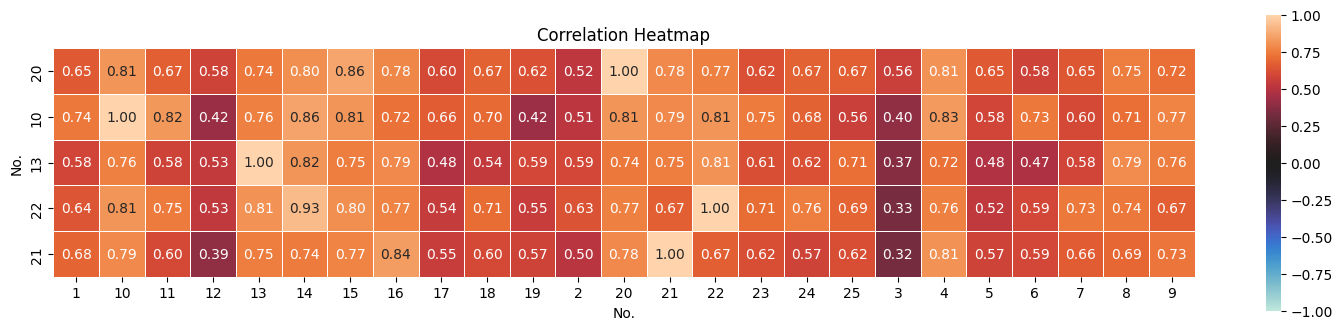

In [ ]:
plt.figure(figsize=(15, 4))
sns.heatmap(wide.corr().loc[['20','10','13','22','21']],vmin=-1, vmax=1, center=0,
            annot=True, fmt=".2f", square=True, linewidths=.5,
            cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
# 분산 큰 문항 index 추출
t5_idx = d_2_csv.loc[(d_2_csv['No.'] == '20') | (d_2_csv['No.'] == '10') | (d_2_csv['No.'] == '13') | (d_2_csv['No.'] == '22') | (d_2_csv['No.'] == '21'),'Target'].index
t4_idx = d_2_csv.loc[(d_2_csv['No.'] == '20') | (d_2_csv['No.'] == '10') | (d_2_csv['No.'] == '13') | (d_2_csv['No.'] == '22'),'Target'].index
t3_idx = d_2_csv.loc[(d_2_csv['No.'] == '20') | (d_2_csv['No.'] == '10') | (d_2_csv['No.'] == '13'),'Target'].index
t2_idx = d_2_csv.loc[(d_2_csv['No.'] == '20') | (d_2_csv['No.'] == '10'),'Target'].index
t1_idx = d_2_csv.loc[(d_2_csv['No.'] == '20'),'Target'].index

In [ ]:
# 분산 top5 추출
x_data_t5 = x_data[t5_idx]
x_data_length_t5 = x_data_length[t5_idx]
sub_x_data_t5 = sub_x_data[t5_idx]
y_data_t5 = y_data[t5_idx]

In [ ]:
# 분산 top4 추출
x_data_t4 = x_data[t4_idx]
x_data_length_t4 = x_data_length[t4_idx]
sub_x_data_t4 = sub_x_data[t4_idx]
y_data_t4 = y_data[t4_idx]

In [ ]:
# 분산 top3 추출
x_data_t3 = x_data[t3_idx]
x_data_length_t3 = x_data_length[t3_idx]
sub_x_data_t3 = sub_x_data[t3_idx]
y_data_t3 = y_data[t3_idx]

In [ ]:
# 분산 top2 추출
x_data_t2 = x_data[t2_idx]
x_data_length_t2 = x_data_length[t2_idx]
sub_x_data_t2 = sub_x_data[t2_idx]
y_data_t2 = y_data[t2_idx]

In [ ]:
# 분산 top1 추출
x_data_t1 = x_data[t1_idx]
x_data_length_t1 = x_data_length[t1_idx]
sub_x_data_t1 = sub_x_data[t1_idx]
y_data_t1 = y_data[t1_idx]

In [ ]:
# train, validation, test split
from sklearn.model_selection import train_test_split

train_x_data_all, test_x_data_all, train_x_data_length_all, test_x_data_length_all, train_sub_x_data_all, test_sub_x_data_all, train_y_data_all, test_y_data_all = train_test_split(
    x_data, x_data_length, sub_x_data, y_data, test_size=0.1, stratify=(y_data))
train_x_data_all, valid_x_data_all, train_x_data_length_all, valid_x_data_length_all, train_sub_x_data_all, valid_sub_x_data_all, train_y_data_all, valid_y_data_all = train_test_split(
    train_x_data_all, train_x_data_length_all, train_sub_x_data_all, train_y_data_all, test_size=0.1, stratify=(train_y_data_all))
print("all train 데이터:",train_x_data_all.shape, train_x_data_length_all.shape, train_sub_x_data_all.shape, train_y_data_all.shape)
print("all valid 데이터:",valid_x_data_all.shape, valid_x_data_length_all.shape, valid_sub_x_data_all.shape, valid_y_data_all.shape)
print("all test 데이터:",test_x_data_all.shape, test_x_data_length_all.shape, test_sub_x_data_all.shape, test_y_data_all.shape)
print()

train_x_data_t5, test_x_data_t5, train_x_data_length_t5, test_x_data_length_t5, train_sub_x_data_t5, test_sub_x_data_t5, train_y_data_t5, test_y_data_t5 = train_test_split(
    x_data_t5, x_data_length_t5, sub_x_data_t5, y_data_t5, test_size=0.1, stratify=(y_data_t5))
train_x_data_t5, valid_x_data_t5, train_x_data_length_t5, valid_x_data_length_t5, train_sub_x_data_t5, valid_sub_x_data_t5, train_y_data_t5, valid_y_data_t5 = train_test_split(
    train_x_data_t5, train_x_data_length_t5, train_sub_x_data_t5, train_y_data_t5, test_size=0.1, stratify=(train_y_data_t5))
print("t5 train 데이터:",train_x_data_t5.shape, train_x_data_length_t5.shape, train_sub_x_data_t5.shape, train_y_data_t5.shape)
print("t5 valid 데이터:",valid_x_data_t5.shape, valid_x_data_length_t5.shape, valid_sub_x_data_t5.shape, valid_y_data_t5.shape)
print("t5 test 데이터:",test_x_data_t5.shape, test_x_data_length_t5.shape, test_sub_x_data_t5.shape, test_y_data_t5.shape)
print()

train_x_data_t4, test_x_data_t4, train_x_data_length_t4, test_x_data_length_t4, train_sub_x_data_t4, test_sub_x_data_t4, train_y_data_t4, test_y_data_t4 = train_test_split(
    x_data_t4, x_data_length_t4, sub_x_data_t4, y_data_t4, test_size=0.1, stratify=(y_data_t4))
train_x_data_t4, valid_x_data_t4, train_x_data_length_t4, valid_x_data_length_t4, train_sub_x_data_t4, valid_sub_x_data_t4, train_y_data_t4, valid_y_data_t4 = train_test_split(
    train_x_data_t4, train_x_data_length_t4, train_sub_x_data_t4, train_y_data_t4, test_size=0.1, stratify=(train_y_data_t4))
print("t4 train 데이터:",train_x_data_t4.shape, train_x_data_length_t4.shape, train_sub_x_data_t4.shape, train_y_data_t4.shape)
print("t4 valid 데이터:",valid_x_data_t4.shape, valid_x_data_length_t4.shape, valid_sub_x_data_t4.shape, valid_y_data_t4.shape)
print("t4 test 데이터:",test_x_data_t4.shape, test_x_data_length_t4.shape, test_sub_x_data_t4.shape, test_y_data_t4.shape)
print()

train_x_data_t3, test_x_data_t3, train_x_data_length_t3, test_x_data_length_t3, train_sub_x_data_t3, test_sub_x_data_t3, train_y_data_t3, test_y_data_t3 = train_test_split(
    x_data_t3, x_data_length_t3, sub_x_data_t3, y_data_t3, test_size=0.1, stratify=(y_data_t3))
train_x_data_t3, valid_x_data_t3, train_x_data_length_t3, valid_x_data_length_t3, train_sub_x_data_t3, valid_sub_x_data_t3, train_y_data_t3, valid_y_data_t3 = train_test_split(
    train_x_data_t3, train_x_data_length_t3, train_sub_x_data_t3, train_y_data_t3, test_size=0.1, stratify=(train_y_data_t3))
print("t3 train 데이터:",train_x_data_t3.shape, train_x_data_length_t3.shape, train_sub_x_data_t3.shape, train_y_data_t3.shape)
print("t3 valid 데이터:",valid_x_data_t3.shape, valid_x_data_length_t3.shape, valid_sub_x_data_t3.shape, valid_y_data_t3.shape)
print("t3 test 데이터:",test_x_data_t3.shape, test_x_data_length_t3.shape, test_sub_x_data_t3.shape, test_y_data_t3.shape)
print()

train_x_data_t2, test_x_data_t2, train_x_data_length_t2, test_x_data_length_t2, train_sub_x_data_t2, test_sub_x_data_t2, train_y_data_t2, test_y_data_t2 = train_test_split(
    x_data_t2, x_data_length_t2, sub_x_data_t2, y_data_t2, test_size=0.1, stratify=(y_data_t2))
train_x_data_t2, valid_x_data_t2, train_x_data_length_t2, valid_x_data_length_t2, train_sub_x_data_t2, valid_sub_x_data_t2, train_y_data_t2, valid_y_data_t2 = train_test_split(
    train_x_data_t2, train_x_data_length_t2, train_sub_x_data_t2, train_y_data_t2, test_size=0.1, stratify=(train_y_data_t2))
print("t2 train 데이터:",train_x_data_t2.shape, train_x_data_length_t2.shape, train_sub_x_data_t2.shape, train_y_data_t2.shape)
print("t2 valid 데이터:",valid_x_data_t2.shape, valid_x_data_length_t2.shape, valid_sub_x_data_t2.shape, valid_y_data_t2.shape)
print("t2 test 데이터:",test_x_data_t2.shape, test_x_data_length_t2.shape, test_sub_x_data_t2.shape, test_y_data_t2.shape)
print()

train_x_data_t1, test_x_data_t1, train_x_data_length_t1, test_x_data_length_t1, train_sub_x_data_t1, test_sub_x_data_t1, train_y_data_t1, test_y_data_t1 = train_test_split(
    x_data_t1, x_data_length_t1, sub_x_data_t1, y_data_t1, test_size=0.1, stratify=(y_data_t1))
train_x_data_t1, valid_x_data_t1, train_x_data_length_t1, valid_x_data_length_t1, train_sub_x_data_t1, valid_sub_x_data_t1, train_y_data_t1, valid_y_data_t1 = train_test_split(
    train_x_data_t1, train_x_data_length_t1, train_sub_x_data_t1, train_y_data_t1, test_size=0.1, stratify=(train_y_data_t1))
print("t1 train 데이터:",train_x_data_t1.shape, train_x_data_length_t1.shape, train_sub_x_data_t1.shape, train_y_data_t1.shape)
print("t1 valid 데이터:",valid_x_data_t1.shape, valid_x_data_length_t1.shape, valid_sub_x_data_t1.shape, valid_y_data_t1.shape)
print("t1 test 데이터:",test_x_data_t1.shape, test_x_data_length_t1.shape, test_sub_x_data_t1.shape, test_y_data_t1.shape)

all train 데이터: (1377, 312, 80) (1377,) (1377, 12) (1377,)
all valid 데이터: (153, 312, 80) (153,) (153, 12) (153,)
all test 데이터: (170, 312, 80) (170,) (170, 12) (170,)

t5 train 데이터: (275, 312, 80) (275,) (275, 12) (275,)
t5 valid 데이터: (31, 312, 80) (31,) (31, 12) (31,)
t5 test 데이터: (34, 312, 80) (34,) (34, 12) (34,)

t4 train 데이터: (219, 312, 80) (219,) (219, 12) (219,)
t4 valid 데이터: (25, 312, 80) (25,) (25, 12) (25,)
t4 test 데이터: (28, 312, 80) (28,) (28, 12) (28,)

t3 train 데이터: (164, 312, 80) (164,) (164, 12) (164,)
t3 valid 데이터: (19, 312, 80) (19,) (19, 12) (19,)
t3 test 데이터: (21, 312, 80) (21,) (21, 12) (21,)

t2 train 데이터: (109, 312, 80) (109,) (109, 12) (109,)
t2 valid 데이터: (13, 312, 80) (13,) (13, 12) (13,)
t2 test 데이터: (14, 312, 80) (14,) (14, 12) (14,)

t1 train 데이터: (54, 312, 80) (54,) (54, 12) (54,)
t1 valid 데이터: (7, 312, 80) (7,) (7, 12) (7,)
t1 test 데이터: (7, 312, 80) (7,) (7, 12) (7,)


In [ ]:
# 전체항목

train_x_data_all_pre_aug, test_x_data_all_aug, train_x_data_length_all_pre_aug, test_x_data_length_all_aug, train_sub_x_data_all_pre_aug, test_sub_x_data_all_aug, train_y_data_all_pre_aug, test_y_data_all_aug = train_test_split(
    x_data, x_data_length, sub_x_data, y_data, test_size=0.1, stratify=(y_data))

train_x_data_all_pre_aug, valid_x_data_all_aug, train_x_data_length_all_pre_aug, valid_x_data_length_all_aug, train_sub_x_data_all_pre_aug, valid_sub_x_data_all_aug, train_y_data_all_pre_aug, valid_y_data_all_aug = train_test_split(
    train_x_data_all_pre_aug, train_x_data_length_all_pre_aug, train_sub_x_data_all_pre_aug, train_y_data_all_pre_aug, test_size=0.1, stratify=(train_y_data_all_pre_aug))

# target != 1 데이터 만 train dataset 증강 (피치, 속도 조정)
all_idx_n_1 = np.where(train_y_data_all_pre_aug != 1)

train_x_data_all_pre_aug_n1 = train_x_data_all_pre_aug[all_idx_n_1]
train_x_data_length_all_pre_aug_n1 = train_x_data_length_all_pre_aug[all_idx_n_1]
train_sub_x_data_all_pre_aug_n1 = train_sub_x_data_all_pre_aug[all_idx_n_1]
train_y_data_all_pre_aug_n1 = train_y_data_all_pre_aug[all_idx_n_1]

print("====================전체 데이터 증강====================")
train_x_data_all_n1_aug_01, train_x_data_length_all_n1_aug_01, train_sub_x_data_all_n1_aug_01, train_y_data_all_n1_aug_01 = make_aug_dataset_pitch_speed(
    train_x_data_all_pre_aug_n1,train_x_data_length_all_pre_aug_n1,train_sub_x_data_all_pre_aug_n1,train_y_data_all_pre_aug_n1,len(train_x_data_all_pre_aug_n1))
print("원본 + 증강:",train_x_data_all_n1_aug_01.shape, train_x_data_length_all_n1_aug_01.shape, train_sub_x_data_all_n1_aug_01.shape, train_y_data_all_n1_aug_01.shape)

train_x_data_all_n1_aug = np.concatenate([train_x_data_all_n1_aug_01], axis=0)
train_x_data_length_all_n1_aug = np.concatenate([train_x_data_length_all_n1_aug_01], axis=0)
train_sub_x_data_all_n1_aug = np.concatenate([train_sub_x_data_all_n1_aug_01], axis=0)
train_y_data_all_n1_aug = np.concatenate([train_y_data_all_n1_aug_01], axis=0)
print("증강 concat:",train_x_data_all_n1_aug.shape, train_x_data_length_all_n1_aug.shape, train_sub_x_data_all_n1_aug.shape, train_y_data_all_n1_aug.shape)

all_idx_y_1 = np.where(train_y_data_all_pre_aug == 1)
train_x_data_all_pre_aug_y1 = train_x_data_all_pre_aug[all_idx_y_1]
train_x_data_length_all_pre_aug_y1 = train_x_data_length_all_pre_aug[all_idx_y_1]
train_sub_x_data_all_pre_aug_y1 = train_sub_x_data_all_pre_aug[all_idx_y_1]
train_y_data_all_pre_aug_y1 = train_y_data_all_pre_aug[all_idx_y_1]
print("y1 shape:",train_x_data_all_pre_aug_y1.shape, train_x_data_length_all_pre_aug_y1.shape, train_sub_x_data_all_pre_aug_y1.shape, train_y_data_all_pre_aug_y1.shape)


train_x_data_all_aug = np.concatenate([train_x_data_all_n1_aug, train_x_data_all_pre_aug_y1], axis=0)
train_x_data_length_all_aug = np.concatenate([train_x_data_length_all_n1_aug, train_x_data_length_all_pre_aug_y1], axis=0)
train_sub_x_data_all_aug = np.concatenate([train_sub_x_data_all_n1_aug, train_sub_x_data_all_pre_aug_y1], axis=0)
train_y_data_all_aug = np.concatenate([train_y_data_all_n1_aug, train_y_data_all_pre_aug_y1], axis=0)


print("train 데이터:",train_x_data_all_aug.shape, train_x_data_length_all_aug.shape, train_sub_x_data_all_aug.shape, train_y_data_all_aug.shape)
print("valid 데이터:",valid_x_data_all_aug.shape, valid_x_data_length_all_aug.shape, valid_sub_x_data_all_aug.shape, valid_y_data_all_aug.shape)
print("test 데이터:",test_x_data_all_aug.shape, test_x_data_length_all_aug.shape, test_sub_x_data_all_aug.shape, test_y_data_all_aug.shape)

====================전체 데이터 증강====================
원본 + 증강: (686, 312, 80) (686,) (686, 12) (686,)
증강 concat: (686, 312, 80) (686,) (686, 12) (686,)
y1 shape: (1034, 312, 80) (1034,) (1034, 12) (1034,)
train 데이터: (1720, 312, 80) (1720,) (1720, 12) (1720,)
valid 데이터: (153, 312, 80) (153,) (153, 12) (153,)
test 데이터: (170, 312, 80) (170,) (170, 12) (170,)


In [ ]:
# train, validation, test split

train_x_data_t5_pre_aug, test_x_data_t5_aug, train_x_data_length_t5_pre_aug, test_x_data_length_t5_aug, train_sub_x_data_t5_pre_aug, test_sub_x_data_t5_aug, train_y_data_t5_pre_aug, test_y_data_t5_aug = train_test_split(
    x_data_t5, x_data_length_t5, sub_x_data_t5, y_data_t5, test_size=0.1, stratify=(y_data_t5))

train_x_data_t5_pre_aug, valid_x_data_t5_aug, train_x_data_length_t5_pre_aug, valid_x_data_length_t5_aug, train_sub_x_data_t5_pre_aug, valid_sub_x_data_t5_aug, train_y_data_t5_pre_aug, valid_y_data_t5_aug = train_test_split(
    train_x_data_t5_pre_aug, train_x_data_length_t5_pre_aug, train_sub_x_data_t5_pre_aug, train_y_data_t5_pre_aug, test_size=0.1, stratify=(train_y_data_t5_pre_aug))

# target != 1 데이터 만 train dataset 증강 (피치, 속도 조정)
t5_idx_n_1 = np.where(train_y_data_t5_pre_aug != 1)

train_x_data_t5_pre_aug_n1 = train_x_data_t5_pre_aug[t5_idx_n_1]
train_x_data_length_t5_pre_aug_n1 = train_x_data_length_t5_pre_aug[t5_idx_n_1]
train_sub_x_data_t5_pre_aug_n1 = train_sub_x_data_t5_pre_aug[t5_idx_n_1]
train_y_data_t5_pre_aug_n1 = train_y_data_t5_pre_aug[t5_idx_n_1]

print("====================전체 데이터 증강====================")
train_x_data_t5_n1_aug_01, train_x_data_length_t5_n1_aug_01, train_sub_x_data_t5_n1_aug_01, train_y_data_t5_n1_aug_01 = make_aug_dataset_pitch_speed(
    train_x_data_t5_pre_aug_n1,train_x_data_length_t5_pre_aug_n1,train_sub_x_data_t5_pre_aug_n1,train_y_data_t5_pre_aug_n1,len(train_x_data_t5_pre_aug_n1))
print("원본 + 증강:",train_x_data_t5_n1_aug_01.shape, train_x_data_length_t5_n1_aug_01.shape, train_sub_x_data_t5_n1_aug_01.shape, train_y_data_t5_n1_aug_01.shape)

train_x_data_t5_n1_aug = np.concatenate([train_x_data_t5_n1_aug_01], axis=0)
train_x_data_length_t5_n1_aug = np.concatenate([train_x_data_length_t5_n1_aug_01], axis=0)
train_sub_x_data_t5_n1_aug = np.concatenate([train_sub_x_data_t5_n1_aug_01], axis=0)
train_y_data_t5_n1_aug = np.concatenate([train_y_data_t5_n1_aug_01], axis=0)
print("증강 concat:",train_x_data_t5_n1_aug.shape, train_x_data_length_t5_n1_aug.shape, train_sub_x_data_t5_n1_aug.shape, train_y_data_t5_n1_aug.shape)

t5_idx_y_1 = np.where(train_y_data_t5_pre_aug == 1)
train_x_data_t5_pre_aug_y1 = train_x_data_t5_pre_aug[t5_idx_y_1]
train_x_data_length_t5_pre_aug_y1 = train_x_data_length_t5_pre_aug[t5_idx_y_1]
train_sub_x_data_t5_pre_aug_y1 = train_sub_x_data_t5_pre_aug[t5_idx_y_1]
train_y_data_t5_pre_aug_y1 = train_y_data_t5_pre_aug[t5_idx_y_1]
print("y1 shape:",train_x_data_t5_pre_aug_y1.shape, train_x_data_length_t5_pre_aug_y1.shape, train_sub_x_data_t5_pre_aug_y1.shape, train_y_data_t5_pre_aug_y1.shape)


train_x_data_t5_aug = np.concatenate([train_x_data_t5_n1_aug, train_x_data_t5_pre_aug_y1], axis=0)
train_x_data_length_t5_aug = np.concatenate([train_x_data_length_t5_n1_aug, train_x_data_length_t5_pre_aug_y1], axis=0)
train_sub_x_data_t5_aug = np.concatenate([train_sub_x_data_t5_n1_aug, train_sub_x_data_t5_pre_aug_y1], axis=0)
train_y_data_t5_aug = np.concatenate([train_y_data_t5_n1_aug, train_y_data_t5_pre_aug_y1], axis=0)


print("train 데이터:",train_x_data_t5_aug.shape, train_x_data_length_t5_aug.shape, train_sub_x_data_t5_aug.shape, train_y_data_t5_aug.shape)
print("valid 데이터:",valid_x_data_t5_aug.shape, valid_x_data_length_t5_aug.shape)
print("test 데이터:",test_x_data_t5_aug.shape, test_x_data_length_t5_aug.shape, test_sub_x_data_t5_aug.shape, test_y_data_t5_aug.shape)

====================전체 데이터 증강====================
원본 + 증강: (162, 312, 80) (162,) (162, 12) (162,)
증강 concat: (162, 312, 80) (162,) (162, 12) (162,)
y1 shape: (194, 312, 80) (194,) (194, 12) (194,)
train 데이터: (356, 312, 80) (356,) (356, 12) (356,)
valid 데이터: (31, 312, 80) (31,)
test 데이터: (34, 312, 80) (34,) (34, 12) (34,)


In [ ]:
# train, validation, test split

train_x_data_t4_pre_aug, test_x_data_t4_aug, train_x_data_length_t4_pre_aug, test_x_data_length_t4_aug, train_sub_x_data_t4_pre_aug, test_sub_x_data_t4_aug, train_y_data_t4_pre_aug, test_y_data_t4_aug = train_test_split(
    x_data_t4, x_data_length_t4, sub_x_data_t4, y_data_t4, test_size=0.1, stratify=(y_data_t4))

train_x_data_t4_pre_aug, valid_x_data_t4_aug, train_x_data_length_t4_pre_aug, valid_x_data_length_t4_aug, train_sub_x_data_t4_pre_aug, valid_sub_x_data_t4_aug, train_y_data_t4_pre_aug, valid_y_data_t4_aug = train_test_split(
    train_x_data_t4_pre_aug, train_x_data_length_t4_pre_aug, train_sub_x_data_t4_pre_aug, train_y_data_t4_pre_aug, test_size=0.1, stratify=(train_y_data_t4_pre_aug))

# target != 1 데이터 만 train dataset 증강 (피치, 속도 조정)
t4_idx_n_1 = np.where(train_y_data_t4_pre_aug != 1)

train_x_data_t4_pre_aug_n1 = train_x_data_t4_pre_aug[t4_idx_n_1]
train_x_data_length_t4_pre_aug_n1 = train_x_data_length_t4_pre_aug[t4_idx_n_1]
train_sub_x_data_t4_pre_aug_n1 = train_sub_x_data_t4_pre_aug[t4_idx_n_1]
train_y_data_t4_pre_aug_n1 = train_y_data_t4_pre_aug[t4_idx_n_1]

print("====================전체 데이터 증강====================")
train_x_data_t4_n1_aug_01, train_x_data_length_t4_n1_aug_01, train_sub_x_data_t4_n1_aug_01, train_y_data_t4_n1_aug_01 = make_aug_dataset_pitch_speed(
    train_x_data_t4_pre_aug_n1,train_x_data_length_t4_pre_aug_n1,train_sub_x_data_t4_pre_aug_n1,train_y_data_t4_pre_aug_n1,len(train_x_data_t4_pre_aug_n1))
print("원본 + 증강:",train_x_data_t4_n1_aug_01.shape, train_x_data_length_t4_n1_aug_01.shape, train_sub_x_data_t4_n1_aug_01.shape, train_y_data_t4_n1_aug_01.shape)

train_x_data_t4_n1_aug = np.concatenate([train_x_data_t4_n1_aug_01], axis=0)
train_x_data_length_t4_n1_aug = np.concatenate([train_x_data_length_t4_n1_aug_01], axis=0)
train_sub_x_data_t4_n1_aug = np.concatenate([train_sub_x_data_t4_n1_aug_01], axis=0)
train_y_data_t4_n1_aug = np.concatenate([train_y_data_t4_n1_aug_01], axis=0)
print("증강 concat:",train_x_data_t4_n1_aug.shape, train_x_data_length_t4_n1_aug.shape, train_sub_x_data_t4_n1_aug.shape, train_y_data_t4_n1_aug.shape)

t4_idx_y_1 = np.where(train_y_data_t4_pre_aug == 1)
train_x_data_t4_pre_aug_y1 = train_x_data_t4_pre_aug[t4_idx_y_1]
train_x_data_length_t4_pre_aug_y1 = train_x_data_length_t4_pre_aug[t4_idx_y_1]
train_sub_x_data_t4_pre_aug_y1 = train_sub_x_data_t4_pre_aug[t4_idx_y_1]
train_y_data_t4_pre_aug_y1 = train_y_data_t4_pre_aug[t4_idx_y_1]
print("y1 shape:",train_x_data_t4_pre_aug_y1.shape, train_x_data_length_t4_pre_aug_y1.shape, train_sub_x_data_t4_pre_aug_y1.shape, train_y_data_t4_pre_aug_y1.shape)


train_x_data_t4_aug = np.concatenate([train_x_data_t4_n1_aug, train_x_data_t4_pre_aug_y1], axis=0)
train_x_data_length_t4_aug = np.concatenate([train_x_data_length_t4_n1_aug, train_x_data_length_t4_pre_aug_y1], axis=0)
train_sub_x_data_t4_aug = np.concatenate([train_sub_x_data_t4_n1_aug, train_sub_x_data_t4_pre_aug_y1], axis=0)
train_y_data_t4_aug = np.concatenate([train_y_data_t4_n1_aug, train_y_data_t4_pre_aug_y1], axis=0)


print("train 데이터:",train_x_data_t4_aug.shape, train_x_data_length_t4_aug.shape, train_sub_x_data_t4_aug.shape, train_y_data_t4_aug.shape)
print("valid 데이터:",valid_x_data_t4_aug.shape, valid_x_data_length_t4_aug.shape)
print("test 데이터:",test_x_data_t4_aug.shape, test_x_data_length_t4_aug.shape, test_sub_x_data_t4_aug.shape, test_y_data_t4_aug.shape)

====================전체 데이터 증강====================
원본 + 증강: (140, 312, 80) (140,) (140, 12) (140,)
증강 concat: (140, 312, 80) (140,) (140, 12) (140,)
y1 shape: (149, 312, 80) (149,) (149, 12) (149,)
train 데이터: (289, 312, 80) (289,) (289, 12) (289,)
valid 데이터: (25, 312, 80) (25,)
test 데이터: (28, 312, 80) (28,) (28, 12) (28,)


In [ ]:
# train, validation, test split

train_x_data_t3_pre_aug, test_x_data_t3_aug, train_x_data_length_t3_pre_aug, test_x_data_length_t3_aug, train_sub_x_data_t3_pre_aug, test_sub_x_data_t3_aug, train_y_data_t3_pre_aug, test_y_data_t3_aug = train_test_split(
    x_data_t3, x_data_length_t3, sub_x_data_t3, y_data_t3, test_size=0.1, stratify=(y_data_t3))

train_x_data_t3_pre_aug, valid_x_data_t3_aug, train_x_data_length_t3_pre_aug, valid_x_data_length_t3_aug, train_sub_x_data_t3_pre_aug, valid_sub_x_data_t3_aug, train_y_data_t3_pre_aug, valid_y_data_t3_aug = train_test_split(
    train_x_data_t3_pre_aug, train_x_data_length_t3_pre_aug, train_sub_x_data_t3_pre_aug, train_y_data_t3_pre_aug, test_size=0.1, stratify=(train_y_data_t3_pre_aug))

# target != 1 데이터 만 train dataset 증강 (피치, 속도 조정)
t3_idx_n_1 = np.where(train_y_data_t3_pre_aug != 1)

train_x_data_t3_pre_aug_n1 = train_x_data_t3_pre_aug[t3_idx_n_1]
train_x_data_length_t3_pre_aug_n1 = train_x_data_length_t3_pre_aug[t3_idx_n_1]
train_sub_x_data_t3_pre_aug_n1 = train_sub_x_data_t3_pre_aug[t3_idx_n_1]
train_y_data_t3_pre_aug_n1 = train_y_data_t3_pre_aug[t3_idx_n_1]

print("====================전체 데이터 증강====================")
train_x_data_t3_n1_aug_01, train_x_data_length_t3_n1_aug_01, train_sub_x_data_t3_n1_aug_01, train_y_data_t3_n1_aug_01 = make_aug_dataset_pitch_speed(
    train_x_data_t3_pre_aug_n1,train_x_data_length_t3_pre_aug_n1,train_sub_x_data_t3_pre_aug_n1,train_y_data_t3_pre_aug_n1,len(train_x_data_t3_pre_aug_n1))
print("원본 + 증강:",train_x_data_t3_n1_aug_01.shape, train_x_data_length_t3_n1_aug_01.shape, train_sub_x_data_t3_n1_aug_01.shape, train_y_data_t3_n1_aug_01.shape)

train_x_data_t3_n1_aug = np.concatenate([train_x_data_t3_n1_aug_01], axis=0)
train_x_data_length_t3_n1_aug = np.concatenate([train_x_data_length_t3_n1_aug_01], axis=0)
train_sub_x_data_t3_n1_aug = np.concatenate([train_sub_x_data_t3_n1_aug_01], axis=0)
train_y_data_t3_n1_aug = np.concatenate([train_y_data_t3_n1_aug_01], axis=0)
print("증강 concat:",train_x_data_t3_n1_aug.shape, train_x_data_length_t3_n1_aug.shape, train_sub_x_data_t3_n1_aug.shape, train_y_data_t3_n1_aug.shape)

t3_idx_y_1 = np.where(train_y_data_t3_pre_aug == 1)
train_x_data_t3_pre_aug_y1 = train_x_data_t3_pre_aug[t3_idx_y_1]
train_x_data_length_t3_pre_aug_y1 = train_x_data_length_t3_pre_aug[t3_idx_y_1]
train_sub_x_data_t3_pre_aug_y1 = train_sub_x_data_t3_pre_aug[t3_idx_y_1]
train_y_data_t3_pre_aug_y1 = train_y_data_t3_pre_aug[t3_idx_y_1]
print("y1 shape:",train_x_data_t3_pre_aug_y1.shape, train_x_data_length_t3_pre_aug_y1.shape, train_sub_x_data_t3_pre_aug_y1.shape, train_y_data_t3_pre_aug_y1.shape)


train_x_data_t3_aug = np.concatenate([train_x_data_t3_n1_aug, train_x_data_t3_pre_aug_y1], axis=0)
train_x_data_length_t3_aug = np.concatenate([train_x_data_length_t3_n1_aug, train_x_data_length_t3_pre_aug_y1], axis=0)
train_sub_x_data_t3_aug = np.concatenate([train_sub_x_data_t3_n1_aug, train_sub_x_data_t3_pre_aug_y1], axis=0)
train_y_data_t3_aug = np.concatenate([train_y_data_t3_n1_aug, train_y_data_t3_pre_aug_y1], axis=0)


print("train 데이터:",train_x_data_t3_aug.shape, train_x_data_length_t3_aug.shape, train_sub_x_data_t3_aug.shape, train_y_data_t3_aug.shape)
print("valid 데이터:",valid_x_data_t3_aug.shape, valid_x_data_length_t3_aug.shape)
print("test 데이터:",test_x_data_t3_aug.shape, test_x_data_length_t3_aug.shape, test_sub_x_data_t3_aug.shape, test_y_data_t3_aug.shape)

====================전체 데이터 증강====================
원본 + 증강: (112, 312, 80) (112,) (112, 12) (112,)
증강 concat: (112, 312, 80) (112,) (112, 12) (112,)
y1 shape: (108, 312, 80) (108,) (108, 12) (108,)
train 데이터: (220, 312, 80) (220,) (220, 12) (220,)
valid 데이터: (19, 312, 80) (19,)
test 데이터: (21, 312, 80) (21,) (21, 12) (21,)


In [ ]:
# train, validation, test split

train_x_data_t2_pre_aug, test_x_data_t2_aug, train_x_data_length_t2_pre_aug, test_x_data_length_t2_aug, train_sub_x_data_t2_pre_aug, test_sub_x_data_t2_aug, train_y_data_t2_pre_aug, test_y_data_t2_aug = train_test_split(
    x_data_t2, x_data_length_t2, sub_x_data_t2, y_data_t2, test_size=0.1, stratify=(y_data_t2))

train_x_data_t2_pre_aug, valid_x_data_t2_aug, train_x_data_length_t2_pre_aug, valid_x_data_length_t2_aug, train_sub_x_data_t2_pre_aug, valid_sub_x_data_t2_aug, train_y_data_t2_pre_aug, valid_y_data_t2_aug = train_test_split(
    train_x_data_t2_pre_aug, train_x_data_length_t2_pre_aug, train_sub_x_data_t2_pre_aug, train_y_data_t2_pre_aug, test_size=0.1, stratify=(train_y_data_t2_pre_aug))

# target != 1 데이터 만 train dataset 증강 (피치, 속도 조정)
t2_idx_n_1 = np.where(train_y_data_t2_pre_aug != 1)

train_x_data_t2_pre_aug_n1 = train_x_data_t2_pre_aug[t2_idx_n_1]
train_x_data_length_t2_pre_aug_n1 = train_x_data_length_t2_pre_aug[t2_idx_n_1]
train_sub_x_data_t2_pre_aug_n1 = train_sub_x_data_t2_pre_aug[t2_idx_n_1]
train_y_data_t2_pre_aug_n1 = train_y_data_t2_pre_aug[t2_idx_n_1]

print("====================전체 데이터 증강====================")
train_x_data_t2_n1_aug_01, train_x_data_length_t2_n1_aug_01, train_sub_x_data_t2_n1_aug_01, train_y_data_t2_n1_aug_01 = make_aug_dataset_pitch_speed(
    train_x_data_t2_pre_aug_n1,train_x_data_length_t2_pre_aug_n1,train_sub_x_data_t2_pre_aug_n1,train_y_data_t2_pre_aug_n1,len(train_x_data_t2_pre_aug_n1))
print("원본 + 증강:",train_x_data_t2_n1_aug_01.shape, train_x_data_length_t2_n1_aug_01.shape, train_sub_x_data_t2_n1_aug_01.shape, train_y_data_t2_n1_aug_01.shape)

train_x_data_t2_n1_aug = np.concatenate([train_x_data_t2_n1_aug_01], axis=0)
train_x_data_length_t2_n1_aug = np.concatenate([train_x_data_length_t2_n1_aug_01], axis=0)
train_sub_x_data_t2_n1_aug = np.concatenate([train_sub_x_data_t2_n1_aug_01], axis=0)
train_y_data_t2_n1_aug = np.concatenate([train_y_data_t2_n1_aug_01], axis=0)
print("증강 concat:",train_x_data_t2_n1_aug.shape, train_x_data_length_t2_n1_aug.shape, train_sub_x_data_t2_n1_aug.shape, train_y_data_t2_n1_aug.shape)

t2_idx_y_1 = np.where(train_y_data_t2_pre_aug == 1)
train_x_data_t2_pre_aug_y1 = train_x_data_t2_pre_aug[t2_idx_y_1]
train_x_data_length_t2_pre_aug_y1 = train_x_data_length_t2_pre_aug[t2_idx_y_1]
train_sub_x_data_t2_pre_aug_y1 = train_sub_x_data_t2_pre_aug[t2_idx_y_1]
train_y_data_t2_pre_aug_y1 = train_y_data_t2_pre_aug[t2_idx_y_1]
print("y1 shape:",train_x_data_t2_pre_aug_y1.shape, train_x_data_length_t2_pre_aug_y1.shape, train_sub_x_data_t2_pre_aug_y1.shape, train_y_data_t2_pre_aug_y1.shape)


train_x_data_t2_aug = np.concatenate([train_x_data_t2_n1_aug, train_x_data_t2_pre_aug_y1], axis=0)
train_x_data_length_t2_aug = np.concatenate([train_x_data_length_t2_n1_aug, train_x_data_length_t2_pre_aug_y1], axis=0)
train_sub_x_data_t2_aug = np.concatenate([train_sub_x_data_t2_n1_aug, train_sub_x_data_t2_pre_aug_y1], axis=0)
train_y_data_t2_aug = np.concatenate([train_y_data_t2_n1_aug, train_y_data_t2_pre_aug_y1], axis=0)


print("train 데이터:",train_x_data_t2_aug.shape, train_x_data_length_t2_aug.shape, train_sub_x_data_t2_aug.shape, train_y_data_t2_aug.shape)
print("valid 데이터:",valid_x_data_t2_aug.shape, valid_x_data_length_t2_aug.shape)
print("test 데이터:",test_x_data_t2_aug.shape, test_x_data_length_t2_aug.shape, test_sub_x_data_t2_aug.shape, test_y_data_t2_aug.shape)

====================전체 데이터 증강====================
원본 + 증강: (76, 312, 80) (76,) (76, 12) (76,)
증강 concat: (76, 312, 80) (76,) (76, 12) (76,)
y1 shape: (71, 312, 80) (71,) (71, 12) (71,)
train 데이터: (147, 312, 80) (147,) (147, 12) (147,)
valid 데이터: (13, 312, 80) (13,)
test 데이터: (14, 312, 80) (14,) (14, 12) (14,)


In [ ]:
# train, validation, test split

train_x_data_t1_pre_aug, test_x_data_t1_aug, train_x_data_length_t1_pre_aug, test_x_data_length_t1_aug, train_sub_x_data_t1_pre_aug, test_sub_x_data_t1_aug, train_y_data_t1_pre_aug, test_y_data_t1_aug = train_test_split(
    x_data_t1, x_data_length_t1, sub_x_data_t1, y_data_t1, test_size=0.1, stratify=(y_data_t1))

train_x_data_t1_pre_aug, valid_x_data_t1_aug, train_x_data_length_t1_pre_aug, valid_x_data_length_t1_aug, train_sub_x_data_t1_pre_aug, valid_sub_x_data_t1_aug, train_y_data_t1_pre_aug, valid_y_data_t1_aug = train_test_split(
    train_x_data_t1_pre_aug, train_x_data_length_t1_pre_aug, train_sub_x_data_t1_pre_aug, train_y_data_t1_pre_aug, test_size=0.1, stratify=(train_y_data_t1_pre_aug))

# target != 1 데이터 만 train dataset 증강 (피치, 속도 조정)
t1_idx_n_1 = np.where(train_y_data_t1_pre_aug != 1)

train_x_data_t1_pre_aug_n1 = train_x_data_t1_pre_aug[t1_idx_n_1]
train_x_data_length_t1_pre_aug_n1 = train_x_data_length_t1_pre_aug[t1_idx_n_1]
train_sub_x_data_t1_pre_aug_n1 = train_sub_x_data_t1_pre_aug[t1_idx_n_1]
train_y_data_t1_pre_aug_n1 = train_y_data_t1_pre_aug[t1_idx_n_1]

print("====================전체 데이터 증강====================")
train_x_data_t1_n1_aug_01, train_x_data_length_t1_n1_aug_01, train_sub_x_data_t1_n1_aug_01, train_y_data_t1_n1_aug_01 = make_aug_dataset_pitch_speed(
    train_x_data_t1_pre_aug_n1,train_x_data_length_t1_pre_aug_n1,train_sub_x_data_t1_pre_aug_n1,train_y_data_t1_pre_aug_n1,len(train_x_data_t1_pre_aug_n1))
print("원본 + 증강:",train_x_data_t1_n1_aug_01.shape, train_x_data_length_t1_n1_aug_01.shape, train_sub_x_data_t1_n1_aug_01.shape, train_y_data_t1_n1_aug_01.shape)

train_x_data_t1_n1_aug = np.concatenate([train_x_data_t1_n1_aug_01], axis=0)
train_x_data_length_t1_n1_aug = np.concatenate([train_x_data_length_t1_n1_aug_01], axis=0)
train_sub_x_data_t1_n1_aug = np.concatenate([train_sub_x_data_t1_n1_aug_01], axis=0)
train_y_data_t1_n1_aug = np.concatenate([train_y_data_t1_n1_aug_01], axis=0)
print("증강 concat:",train_x_data_t1_n1_aug.shape, train_x_data_length_t1_n1_aug.shape, train_sub_x_data_t1_n1_aug.shape, train_y_data_t1_n1_aug.shape)

t1_idx_y_1 = np.where(train_y_data_t1_pre_aug == 1)
train_x_data_t1_pre_aug_y1 = train_x_data_t1_pre_aug[t1_idx_y_1]
train_x_data_length_t1_pre_aug_y1 = train_x_data_length_t1_pre_aug[t1_idx_y_1]
train_sub_x_data_t1_pre_aug_y1 = train_sub_x_data_t1_pre_aug[t1_idx_y_1]
train_y_data_t1_pre_aug_y1 = train_y_data_t1_pre_aug[t1_idx_y_1]
print("y1 shape:",train_x_data_t1_pre_aug_y1.shape, train_x_data_length_t1_pre_aug_y1.shape, train_sub_x_data_t1_pre_aug_y1.shape, train_y_data_t1_pre_aug_y1.shape)


train_x_data_t1_aug = np.concatenate([train_x_data_t1_n1_aug, train_x_data_t1_pre_aug_y1], axis=0)
train_x_data_length_t1_aug = np.concatenate([train_x_data_length_t1_n1_aug, train_x_data_length_t1_pre_aug_y1], axis=0)
train_sub_x_data_t1_aug = np.concatenate([train_sub_x_data_t1_n1_aug, train_sub_x_data_t1_pre_aug_y1], axis=0)
train_y_data_t1_aug = np.concatenate([train_y_data_t1_n1_aug, train_y_data_t1_pre_aug_y1], axis=0)


print("train 데이터:",train_x_data_t1_aug.shape, train_x_data_length_t1_aug.shape, train_sub_x_data_t1_aug.shape, train_y_data_t1_aug.shape)
print("valid 데이터:",valid_x_data_t1_aug.shape, valid_x_data_length_t1_aug.shape)
print("test 데이터:",test_x_data_t1_aug.shape, test_x_data_length_t1_aug.shape, test_sub_x_data_t1_aug.shape, test_y_data_t1_aug.shape)

====================전체 데이터 증강====================
원본 + 증강: (46, 312, 80) (46,) (46, 12) (46,)
증강 concat: (46, 312, 80) (46,) (46, 12) (46,)
y1 shape: (31, 312, 80) (31,) (31, 12) (31,)
train 데이터: (77, 312, 80) (77,) (77, 12) (77,)
valid 데이터: (7, 312, 80) (7,)
test 데이터: (7, 312, 80) (7,) (7, 12) (7,)


In [ ]:
def hardtanh(x, min_val=-20.0, max_val=20.0):
    return tf.clip_by_value(x, min_val, max_val)

@tf.keras.utils.register_keras_serializable(package="mask")
class SequenceMask(layers.Layer):
    def call(self, inputs):
        is_padding = tf.reduce_all(tf.equal(inputs, -80.0), axis=[-1,-2])
        is_valid = tf.logical_not(is_padding)
        lengths = tf.reduce_sum(tf.cast(is_valid, tf.int32), axis=-1)
        lengths = tf.math.floordiv(lengths,4)
        return tf.sequence_mask(lengths, maxlen=78)

@tf.keras.utils.register_keras_serializable(package="atten_mask")
def make_attn_mask(masks):
    qmask, kmask = masks
    qmask = tf.keras.ops.expand_dims(qmask, 2)
    kmask = tf.keras.ops.expand_dims(kmask, 1)
    return tf.keras.ops.logical_and(qmask, kmask)

def make_talk_clean_model(input_shape=(312,80,1), model_name=None):

    x_input = tf.keras.Input(shape=input_shape, name="x_input")
    sub_x_input = tf.keras.Input(shape=(12,), dtype='int32', name="sub_x_input")

    # 1. 음성데이터 -> CNN -> GRU
    conv2d_1 = layers.Conv2D(32, kernel_size=(41, 11), strides=(2, 2), padding='same', use_bias=False)
    conv2d_1_out = conv2d_1(x_input)
    BatNor_1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_1_out = BatNor_1(conv2d_1_out)
    hardtanh_1 = layers.Activation(hardtanh)
    hardtanh_1_out = hardtanh_1(BatNor_1_out)

    conv2d_2 = layers.Conv2D(32, kernel_size=(21, 11), strides=(2, 1), padding='same', use_bias=False)
    conv2d_2_out = conv2d_2(hardtanh_1_out)
    BatNor_2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_2_out = BatNor_2(conv2d_2_out)
    hardtanh_2 = layers.Activation(hardtanh)
    hardtanh_2_out = hardtanh_2(BatNor_2_out)

    b, t, f, c = hardtanh_2_out.shape  # batch, time, freq, channel
    Reshape_1 = layers.Reshape((t, -1))
    Reshape_1_out = Reshape_1(hardtanh_2_out)  # merge freq and channel

    BatNor_3 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_3_out = BatNor_3(Reshape_1_out)

    x_data_mask = SequenceMask()(x_input)

    GRU_01 = layers.Bidirectional(layers.GRU(512, dropout=0.1, return_sequences=True), merge_mode='concat')
    GRU_01_out = GRU_01(BatNor_3_out, mask=x_data_mask)


    # 2. Embedding
    Embed_01 = layers.Embedding(input_dim=55, output_dim=16, mask_zero=True)
    Embed_01_out = Embed_01(sub_x_input)
    key_mask  = Embed_01.compute_mask(sub_x_input)


    # 3. Attention
    attn_mask = make_attn_mask([x_data_mask, key_mask])
    MHA_01 = layers.MultiHeadAttention(num_heads=256, key_dim=32, dropout=0.1)
    MHA_01_out = MHA_01(GRU_01_out, Embed_01_out, attention_mask=attn_mask)

    BatNor_4 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_4_out = BatNor_4(MHA_01_out)
    GRU_02 = layers.Bidirectional(layers.GRU(64, dropout=0.1, return_sequences=True), merge_mode='concat')
    GRU_02_out = GRU_02(BatNor_4_out)

    GloAvg_01 = layers.GlobalAveragePooling1D()
    GloAvg_01_out = GloAvg_01(GRU_02_out)

    # Reshape_2 = layers.Reshape((-1,))
    # Reshape_2_out = Reshape_2(MHA_01_out)

    # 4. Dense
    Dense_2 = layers.Dense(1024,activation='relu')
    Dense_2_out = Dense_2(GloAvg_01_out)

    # Dense_4 = layers.Dense(128,activation='relu')
    # Dense_4_out = Dense_4(Dense_2_out)

    Dense_3 = layers.Dense(1,activation='sigmoid')
    Dense_3_out = Dense_3(Dense_2_out)

    if model_name == None:
        return Model(inputs=[x_input,sub_x_input], outputs=Dense_3_out)
    else:
        return Model(inputs=[x_input,sub_x_input], outputs=Dense_3_out, name=f'{model_name}')

model_t1 = make_talk_clean_model(model_name='t1')
model_t2 = make_talk_clean_model(model_name='t2')
model_t3 = make_talk_clean_model(model_name='t3')
model_t4 = make_talk_clean_model(model_name='t4')
model_t5 = make_talk_clean_model(model_name='t5')
model_all = make_talk_clean_model(model_name='all')

model_t1_aug = make_talk_clean_model(model_name='t1_aug')
model_t2_aug = make_talk_clean_model(model_name='t2_aug')
model_t3_aug = make_talk_clean_model(model_name='t3_aug')
model_t4_aug = make_talk_clean_model(model_name='t4_aug')
model_t5_aug = make_talk_clean_model(model_name='t5_aug')
model_all_aug = make_talk_clean_model(model_name='all_aug')

In [ ]:
model_t1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
model_t2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
model_t3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
model_t4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
model_t5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
model_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

model_t1_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
model_t2_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
model_t3_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
model_t4_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
model_t5_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
model_all_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

In [ ]:
# 저장 폴더 지정

save_folder = 'CLAP_D_2_1st'
save_path = f"/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/{save_folder}"

In [ ]:
# 최초 학습

first_train_all = model_all.fit(x=[train_x_data_all,train_sub_x_data_all],
          y=train_y_data_all,
          batch_size=64,
          validation_data=([valid_x_data_all,valid_sub_x_data_all], valid_y_data_all),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_all.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - loss: 0.4800
Epoch 1: val_loss improved from inf to 0.46832, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_all.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.4786 - val_loss: 0.4683
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 0.4145
Epoch 2: val_loss did not improve from 0.46832
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 554ms/step - loss: 0.4149 - val_loss: 0.4827
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 0.4147
Epoch 3: val_loss did not improve from 0.46832
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 548ms/step - loss: 0.4148 - val_loss: 0.5037
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - loss: 0.4161
Epoch 4: val_loss did not improve from 0.46832
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step - loss: 0.4161 - val_loss: 0.5079
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 0.4328
Epoch 5: val_loss did not improve from 0.46832
22/22 ━━

In [ ]:
# 최초 학습

first_train_all_aug = model_all_aug.fit(x=[train_x_data_all_aug,train_sub_x_data_all_aug],
          y=train_y_data_all_aug,
          batch_size=64,
          validation_data=([valid_x_data_all_aug,valid_sub_x_data_all_aug], valid_y_data_all_aug),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_all_aug.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - loss: 0.5742
Epoch 1: val_loss improved from inf to 0.43851, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_all_aug.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.5741 - val_loss: 0.4385
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - loss: 0.5680
Epoch 2: val_loss improved from 0.43851 to 0.42182, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_all_aug.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 664ms/step - loss: 0.5673 - val_loss: 0.4218
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - loss: 0.5325
Epoch 3: val_loss did not improve from 0.42182
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 595ms/step - loss: 0.5327 - val_loss: 0.4248
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - loss: 0.5352
Epoch 4: val_loss did not improve from 0.42182
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 596ms/step - loss: 0.5354 - val_loss: 0.

In [ ]:
# 최초 학습

first_train_t5 = model_t5.fit(x=[train_x_data_t5,train_sub_x_data_t5],
          y=train_y_data_t5,
          batch_size=64,
          validation_data=([valid_x_data_t5,valid_sub_x_data_t5], valid_y_data_t5),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_t5.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - loss: 0.5628
Epoch 1: val_loss improved from inf to 0.65830, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t5.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.5530 - val_loss: 0.6583
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 0.4349
Epoch 2: val_loss did not improve from 0.65830
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 514ms/step - loss: 0.4323 - val_loss: 0.7025
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 0.3879
Epoch 3: val_loss improved from 0.65830 to 0.63641, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t5.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 886ms/step - loss: 0.3899 - val_loss: 0.6364
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 0.3829
Epoch 4: val_loss improved from 0.63641 to 0.51664, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/K

In [ ]:
# 최초 학습

first_train_t5_aug = model_t5_aug.fit(x=[train_x_data_t5_aug,train_sub_x_data_t5_aug],
          y=train_y_data_t5_aug,
          batch_size=64,
          validation_data=([valid_x_data_t5_aug,valid_sub_x_data_t5_aug], valid_y_data_t5_aug),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_t5_aug.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - loss: 0.6141
Epoch 1: val_loss improved from inf to 0.66592, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t5_aug.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 0.6105 - val_loss: 0.6659
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 0.5515
Epoch 2: val_loss did not improve from 0.66592
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - loss: 0.5530 - val_loss: 0.6893
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - loss: 0.5226
Epoch 3: val_loss improved from 0.66592 to 0.60777, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t5_aug.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 890ms/step - loss: 0.5248 - val_loss: 0.6078
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 0.5358
Epoch 4: val_loss improved from 0.60777 to 0.46967, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_

In [ ]:
# 최초 학습

first_train_t4 = model_t4.fit(x=[train_x_data_t4,train_sub_x_data_t4],
          y=train_y_data_t4,
          batch_size=64,
          validation_data=([valid_x_data_t4,valid_sub_x_data_t4], valid_y_data_t4),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_t4.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - loss: 0.6182
Epoch 1: val_loss improved from inf to 0.68455, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t4.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.6060 - val_loss: 0.6846
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 0.4695
Epoch 2: val_loss improved from 0.68455 to 0.67281, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t4.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.4675 - val_loss: 0.6728
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 0.4173
Epoch 3: val_loss improved from 0.67281 to 0.64054, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t4.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.4197 - val_loss: 0.6405
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 0.4044
Epoch 4: val_loss improved from

In [ ]:
# 최초 학습

first_train_t4_aug = model_t4_aug.fit(x=[train_x_data_t4_aug,train_sub_x_data_t4_aug],
          y=train_y_data_t4_aug,
          batch_size=64,
          validation_data=([valid_x_data_t4_aug,valid_sub_x_data_t4_aug], valid_y_data_t4_aug),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_t4_aug.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 0.6245
Epoch 1: val_loss improved from inf to 0.69472, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t4_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.6173 - val_loss: 0.6947
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5489
Epoch 2: val_loss improved from 0.69472 to 0.68519, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t4_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.5492 - val_loss: 0.6852
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 0.5162
Epoch 3: val_loss improved from 0.68519 to 0.64963, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t4_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.5201 - val_loss: 0.6496
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 0.5346
Epoch 4: val_loss i

In [ ]:
# 최초 학습

first_train_t3 = model_t3.fit(x=[train_x_data_t3,train_sub_x_data_t3],
          y=train_y_data_t3,
          batch_size=64,
          validation_data=([valid_x_data_t3,valid_sub_x_data_t3], valid_y_data_t3),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_t3.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 0.6308
Epoch 1: val_loss improved from inf to 0.67070, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t3.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - loss: 0.6247 - val_loss: 0.6707
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.5406
Epoch 2: val_loss did not improve from 0.67070
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 0.5282 - val_loss: 0.6768
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 0.4978
Epoch 3: val_loss did not improve from 0.67070
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step - loss: 0.4907 - val_loss: 0.6970
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - loss: 0.4620
Epoch 4: val_loss did not improve from 0.67070
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - loss: 0.4587 - val_loss: 0.6868
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - loss: 0.4792
Epoch 5: val_loss improved from 0.67070 to 0.64026, saving model to /content/

In [ ]:
# 최초 학습

first_train_t3_aug = model_t3_aug.fit(x=[train_x_data_t3_aug,train_sub_x_data_t3_aug],
          y=train_y_data_t3_aug,
          batch_size=64,
          validation_data=([valid_x_data_t3_aug,valid_sub_x_data_t3_aug], valid_y_data_t3_aug),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_t3_aug.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - loss: 0.6403
Epoch 1: val_loss improved from inf to 0.71347, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t3_aug.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - loss: 0.6312 - val_loss: 0.7135
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 0.5208
Epoch 2: val_loss improved from 0.71347 to 0.70552, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t3_aug.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.5248 - val_loss: 0.7055
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - loss: 0.5386
Epoch 3: val_loss improved from 0.70552 to 0.69062, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t3_aug.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.5383 - val_loss: 0.6906
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - loss: 0.5547
Epoch 4: val_loss

In [ ]:
# 최초 학습

first_train_t2 = model_t2.fit(x=[train_x_data_t2,train_sub_x_data_t2],
          y=train_y_data_t2,
          batch_size=64,
          validation_data=([valid_x_data_t2,valid_sub_x_data_t2], valid_y_data_t2),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_t2.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6612
Epoch 1: val_loss improved from inf to 0.68217, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t2.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 13s/step - loss: 0.6506 - val_loss: 0.6822
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.4566
Epoch 2: val_loss improved from 0.68217 to 0.67335, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t2.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4571 - val_loss: 0.6733
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.4375
Epoch 3: val_loss improved from 0.67335 to 0.66784, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t2.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - loss: 0.4425 - val_loss: 0.6678
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - loss: 0.4422
Epoch 4: val_loss improved from 0

In [ ]:
# 최초 학습

first_train_t2_aug = model_t2_aug.fit(x=[train_x_data_t2_aug,train_sub_x_data_t2_aug],
          y=train_y_data_t2_aug,
          batch_size=64,
          validation_data=([valid_x_data_t2_aug,valid_sub_x_data_t2_aug], valid_y_data_t2_aug),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_t2_aug.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.6498
Epoch 1: val_loss improved from inf to 0.68696, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t2_aug.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 0.6445 - val_loss: 0.6870
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.5475
Epoch 2: val_loss improved from 0.68696 to 0.68200, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t2_aug.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.5464 - val_loss: 0.6820
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 0.5190
Epoch 3: val_loss did not improve from 0.68200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step - loss: 0.5193 - val_loss: 0.6846
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.5068
Epoch 4: val_loss improved from 0.68200 to 0.68160, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_

In [ ]:
# 최초 학습

first_train_t1 = model_t1.fit(x=[train_x_data_t1,train_sub_x_data_t1],
          y=train_y_data_t1,
          batch_size=64,
          validation_data=([valid_x_data_t1,valid_sub_x_data_t1], valid_y_data_t1),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_t1.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.6932
Epoch 1: val_loss improved from inf to 0.68787, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.6932 - val_loss: 0.6879
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.5740
Epoch 2: val_loss improved from 0.68787 to 0.68116, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.5740 - val_loss: 0.6812
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - loss: 0.5300
Epoch 3: val_loss improved from 0.68116 to 0.67270, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.5300 - val_loss: 0.6727
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5280
Epoch 4: val_loss improved from 0.672

In [ ]:
# 최초 학습

first_train_t1_aug = model_t1_aug.fit(x=[train_x_data_t1_aug,train_sub_x_data_t1_aug],
          y=train_y_data_t1_aug,
          batch_size=64,
          validation_data=([valid_x_data_t1_aug,valid_sub_x_data_t1_aug], valid_y_data_t1_aug),
          # validation_split=0.2,
          epochs=100,
          callbacks=[EarlyStopping(monitor='val_loss',patience=10),
                    ModelCheckpoint(filepath=save_path+'/KoSp_tf_CLAP_D_t1_aug.keras', monitor='val_loss', save_best_only=True, verbose=3)]
          )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - loss: 0.6987
Epoch 1: val_loss improved from inf to 0.68565, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t1_aug.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 11s/step - loss: 0.7009 - val_loss: 0.6857
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.6326
Epoch 2: val_loss improved from 0.68565 to 0.68264, saving model to /content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t1_aug.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 11s/step - loss: 0.6279 - val_loss: 0.6826
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.6968
Epoch 3: val_loss did not improve from 0.68264
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - loss: 0.6905 - val_loss: 0.6919
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.6349
Epoch 4: val_loss did not improve from 0.68264
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.6324 - val_loss: 0.7046
Epoch 5/100
2/2 

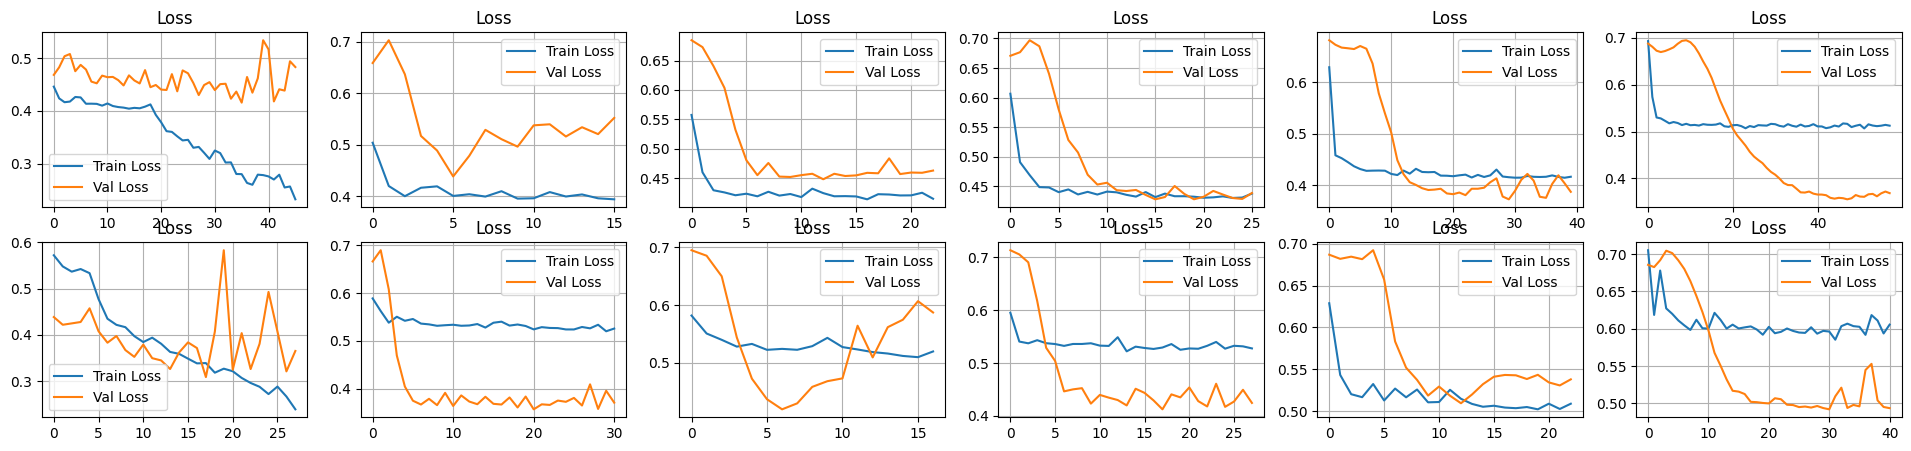

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(24, 5))

# Loss
ax[0,0].plot(first_train_all.history['loss'], label='Train Loss')
ax[0,0].plot(first_train_all.history['val_loss'], label='Val Loss')
ax[0,0].set_title('Loss')
ax[0,0].legend()
ax[0,0].grid(True)

ax[0,1].plot(first_train_t5.history['loss'], label='Train Loss')
ax[0,1].plot(first_train_t5.history['val_loss'], label='Val Loss')
ax[0,1].set_title('Loss')
ax[0,1].legend()
ax[0,1].grid(True)

ax[0,2].plot(first_train_t4.history['loss'], label='Train Loss')
ax[0,2].plot(first_train_t4.history['val_loss'], label='Val Loss')
ax[0,2].set_title('Loss')
ax[0,2].legend()
ax[0,2].grid(True)

ax[0,3].plot(first_train_t3.history['loss'], label='Train Loss')
ax[0,3].plot(first_train_t3.history['val_loss'], label='Val Loss')
ax[0,3].set_title('Loss')
ax[0,3].legend()
ax[0,3].grid(True)

ax[0,4].plot(first_train_t2.history['loss'], label='Train Loss')
ax[0,4].plot(first_train_t2.history['val_loss'], label='Val Loss')
ax[0,4].set_title('Loss')
ax[0,4].legend()
ax[0,4].grid(True)

ax[0,5].plot(first_train_t1.history['loss'], label='Train Loss')
ax[0,5].plot(first_train_t1.history['val_loss'], label='Val Loss')
ax[0,5].set_title('Loss')
ax[0,5].legend()
ax[0,5].grid(True)

ax[1,0].plot(first_train_all_aug.history['loss'], label='Train Loss')
ax[1,0].plot(first_train_all_aug.history['val_loss'], label='Val Loss')
ax[1,0].set_title('Loss')
ax[1,0].legend()
ax[1,0].grid(True)

ax[1,1].plot(first_train_t5_aug.history['loss'], label='Train Loss')
ax[1,1].plot(first_train_t5_aug.history['val_loss'], label='Val Loss')
ax[1,1].set_title('Loss')
ax[1,1].legend()
ax[1,1].grid(True)

ax[1,2].plot(first_train_t4_aug.history['loss'], label='Train Loss')
ax[1,2].plot(first_train_t4_aug.history['val_loss'], label='Val Loss')
ax[1,2].set_title('Loss')
ax[1,2].legend()
ax[1,2].grid(True)

ax[1,3].plot(first_train_t3_aug.history['loss'], label='Train Loss')
ax[1,3].plot(first_train_t3_aug.history['val_loss'], label='Val Loss')
ax[1,3].set_title('Loss')
ax[1,3].legend()
ax[1,3].grid(True)

ax[1,4].plot(first_train_t2_aug.history['loss'], label='Train Loss')
ax[1,4].plot(first_train_t2_aug.history['val_loss'], label='Val Loss')
ax[1,4].set_title('Loss')
ax[1,4].legend()
ax[1,4].grid(True)

ax[1,5].plot(first_train_t1_aug.history['loss'], label='Train Loss')
ax[1,5].plot(first_train_t1_aug.history['val_loss'], label='Val Loss')
ax[1,5].set_title('Loss')
ax[1,5].legend()
ax[1,5].grid(True)

plt.show()

In [ ]:
model_all = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_all.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_all.evaluate([test_x_data_all,test_sub_x_data_all], test_y_data_all)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.3949


0.353128582239151

In [ ]:
model_t5 = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_t5.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_t5.evaluate([test_x_data_t5,test_sub_x_data_t5], test_y_data_t5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.4266


0.4200095534324646

In [ ]:
model_t4 = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_t4.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_t4.evaluate([test_x_data_t4,test_sub_x_data_t4], test_y_data_t4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4455


0.44549617171287537

In [ ]:
model_t3 = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_t3.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_t3.evaluate([test_x_data_t3,test_sub_x_data_t3], test_y_data_t3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3654


0.3654087483882904

In [ ]:
model_t2 = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_t2.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_t2.evaluate([test_x_data_t2,test_sub_x_data_t2], test_y_data_t2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5430


0.5430485606193542

In [ ]:
model_t1 = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_t1.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_t1.evaluate([test_x_data_t1,test_sub_x_data_t1], test_y_data_t1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step - loss: 0.4772


0.47717103362083435

In [ ]:
model_all_aug = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_all_aug.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_all_aug.evaluate([test_x_data_all,test_sub_x_data_all], test_y_data_all)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3132


0.28435468673706055

In [ ]:
model_t5_aug = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_t5_aug.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_t5_aug.evaluate([test_x_data_t5,test_sub_x_data_t5], test_y_data_t5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3826


0.37726089358329773

In [ ]:
model_t4_aug = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_t4_aug.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_t4_aug.evaluate([test_x_data_t4,test_sub_x_data_t4], test_y_data_t4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step - loss: 0.3987


0.39867863059043884

In [ ]:
model_t3_aug = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_t3_aug.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_t3_aug.evaluate([test_x_data_t3,test_sub_x_data_t3], test_y_data_t3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step - loss: 0.3671


0.3670958876609802

In [ ]:
model_t2_aug = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_t2_aug.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_t2_aug.evaluate([test_x_data_t2,test_sub_x_data_t2], test_y_data_t2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step - loss: 0.4878


0.48775529861450195

In [ ]:
model_t1_aug = tf.keras.models.load_model(
  f"{save_path}/KoSp_tf_CLAP_D_t1_aug.keras",
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
  )
model_t1_aug.evaluate([test_x_data_t1,test_sub_x_data_t1], test_y_data_t1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step - loss: 0.4486


0.44858795404434204

In [ ]:
model_all_all_pred_list = model_all.predict([test_x_data_all,test_sub_x_data_all])[:,0]
all_all_corr = np.corrcoef(model_all_all_pred_list, test_y_data_all)[0, 1]
print("all_all 상관계수:", all_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step
all_all 상관계수: 0.6212477415845223


In [ ]:
model_t5_all_pred_list = model_t5.predict([test_x_data_all,test_sub_x_data_all])[:,0]
t5_all_corr = np.corrcoef(model_t5_all_pred_list, test_y_data_all)[0, 1]
print("t5_all 상관계수:", t5_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
t5_all 상관계수: 0.36538119600124563


In [ ]:
model_t4_all_pred_list = model_t4.predict([test_x_data_all,test_sub_x_data_all])[:,0]
t4_all_corr = np.corrcoef(model_t4_all_pred_list, test_y_data_all)[0, 1]
print("t4_all 상관계수:", t4_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
t4_all 상관계수: 0.37601972405903134


In [ ]:
model_t3_all_pred_list = model_t3.predict([test_x_data_all,test_sub_x_data_all])[:,0]
t3_all_corr = np.corrcoef(model_t3_all_pred_list, test_y_data_all)[0, 1]
print("t3_all 상관계수:", t3_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
t3_all 상관계수: 0.40348752401301025


In [ ]:
model_t2_all_pred_list = model_t2.predict([test_x_data_all,test_sub_x_data_all])[:,0]
t2_all_corr = np.corrcoef(model_t2_all_pred_list, test_y_data_all)[0, 1]
print("t2_all 상관계수:", t2_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step
t2_all 상관계수: 0.36458800433429095


In [ ]:
model_t1_all_pred_list = model_t1.predict([test_x_data_all,test_sub_x_data_all])[:,0]
t1_all_corr = np.corrcoef(model_t1_all_pred_list, test_y_data_all)[0, 1]
print("t1_all 상관계수:", t1_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
t1_all 상관계수: 0.4236667011131031


In [ ]:
model_all_aug_all_pred_list = model_all_aug.predict([test_x_data_all,test_sub_x_data_all])[:,0]
all_aug_all_corr = np.corrcoef(model_all_aug_all_pred_list, test_y_data_all)[0, 1]
print("all_aug_all 상관계수:", all_aug_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
all_aug_all 상관계수: 0.7653198841903726


In [ ]:
model_t5_aug_all_pred_list = model_t5_aug.predict([test_x_data_all,test_sub_x_data_all])[:,0]
t5_aug_all_corr = np.corrcoef(model_t5_aug_all_pred_list, test_y_data_all)[0, 1]
print("t5_aug_all 상관계수:", t5_aug_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step
t5_aug_all 상관계수: 0.41156089927562967


In [ ]:
model_t4_aug_all_pred_list = model_t4_aug.predict([test_x_data_all,test_sub_x_data_all])[:,0]
t4_aug_all_corr = np.corrcoef(model_t4_aug_all_pred_list, test_y_data_all)[0, 1]
print("t4_aug_all 상관계수:", t4_aug_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
t4_aug_all 상관계수: 0.4031656819501978


In [ ]:
model_t3_aug_all_pred_list = model_t3_aug.predict([test_x_data_all,test_sub_x_data_all])[:,0]
t3_aug_all_corr = np.corrcoef(model_t3_aug_all_pred_list, test_y_data_all)[0, 1]
print("t3_aug_all 상관계수:", t3_aug_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
t3_aug_all 상관계수: 0.4183799954468265


In [ ]:
model_t2_aug_all_pred_list = model_t2_aug.predict([test_x_data_all,test_sub_x_data_all])[:,0]
t2_aug_all_corr = np.corrcoef(model_t2_aug_all_pred_list, test_y_data_all)[0, 1]
print("t2_aug_all 상관계수:", t2_aug_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step
t2_aug_all 상관계수: 0.3906290061302546


In [ ]:
model_t1_aug_all_pred_list = model_t1_aug.predict([test_x_data_all,test_sub_x_data_all])[:,0]
t1_aug_all_corr = np.corrcoef(model_t1_aug_all_pred_list, test_y_data_all)[0, 1]
print("t1_aug_all 상관계수:", t1_aug_all_corr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
t1_aug_all 상관계수: 0.3596406799927914


In [ ]:
def hardtanh(x, min_val=-20.0, max_val=20.0):
    return tf.clip_by_value(x, min_val, max_val)

@tf.keras.utils.register_keras_serializable(package="mask")
class SequenceMask(layers.Layer):
    def call(self, inputs):
        is_padding = tf.reduce_all(tf.equal(inputs, -80.0), axis=[-1,-2])
        is_valid = tf.logical_not(is_padding)
        lengths = tf.reduce_sum(tf.cast(is_valid, tf.int32), axis=-1)
        lengths = tf.math.floordiv(lengths,4)
        return tf.sequence_mask(lengths, maxlen=78)

@tf.keras.utils.register_keras_serializable(package="atten_mask")
def make_attn_mask(masks):
    qmask, kmask = masks
    qmask = tf.keras.ops.expand_dims(qmask, 2)
    kmask = tf.keras.ops.expand_dims(kmask, 1)
    return tf.keras.ops.logical_and(qmask, kmask)

In [ ]:
def pred_preprocess(wav_path, sr=16000, n_mels=80):
  pred_wav = wav_path
  pred_,_,_ = audio_preprocess(pred_wav,sr,n_mels)
  padd_pred = wav_padding(pred_)
  x_padded_pred_data = np.stack([padd_pred])
  pred_audio_transposed = np.transpose(x_padded_pred_data, (0, 2, 1))
  x_pred_data = np.expand_dims(pred_audio_transposed, axis=-1)
  return x_pred_data

In [ ]:
model_list = glob.glob(f"{save_path}/*.keras")

for model_path in model_list:
  print(f"=========={model_path} 시작==========")
  pred_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
      "hardtanh": hardtanh,
      "SequenceMask": SequenceMask,
      "make_attn_mask": make_attn_mask,
      'CTC': CTC()
      }
  )

  pred_score = pred_model.predict([x_data, sub_x_data])
  for idx,i in enumerate(pred_score):
    col_name = model_path.split('/')[-1].split('.')[0]
    d_2_csv.loc[idx,col_name] = np.round(pred_score[idx]*d_2_csv.loc[idx,"Score(Alloc)"],0)

==========/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_all.keras 시작==========
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step
==========/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_all_aug.keras 시작==========
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step
==========/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t5.keras 시작==========
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step
==========/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t5_aug.keras 시작==========
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step
==========/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t4.keras 시작==========
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step
==========/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_t4_aug.keras 시작==========
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step
==========/content/d

In [ ]:
d_2_csv.columns

Index(['Path', 'File Name', 'Duration', 'Rate', 'Score(Refer)', 'Score(Alloc)',
       'Note', 'P_Num', 'New_Path', 'No.', 'Target', 'KoSp_tf_CLAP_D_all',
       'KoSp_tf_CLAP_D_all_aug', 'KoSp_tf_CLAP_D_t5', 'KoSp_tf_CLAP_D_t5_aug',
       'KoSp_tf_CLAP_D_t4', 'KoSp_tf_CLAP_D_t4_aug', 'KoSp_tf_CLAP_D_t3',
       'KoSp_tf_CLAP_D_t3_aug', 'KoSp_tf_CLAP_D_t2', 'KoSp_tf_CLAP_D_t2_aug',
       'KoSp_tf_CLAP_D_t1', 'KoSp_tf_CLAP_D_t1_aug'],
      dtype='object')

In [ ]:
corr_df = d_2_csv[['P_Num','KoSp_tf_CLAP_D_all','KoSp_tf_CLAP_D_all_aug','KoSp_tf_CLAP_D_t5','KoSp_tf_CLAP_D_t5_aug','KoSp_tf_CLAP_D_t4','KoSp_tf_CLAP_D_t4_aug', 'KoSp_tf_CLAP_D_t3','KoSp_tf_CLAP_D_t3_aug','KoSp_tf_CLAP_D_t2','KoSp_tf_CLAP_D_t2_aug','KoSp_tf_CLAP_D_t1','KoSp_tf_CLAP_D_t1_aug','Score(Refer)']]

In [ ]:
corr_df.corr()

,P_Num,KoSp_tf_CLAP_D_all,KoSp_tf_CLAP_D_all_aug,KoSp_tf_CLAP_D_t5,KoSp_tf_CLAP_D_t5_aug,KoSp_tf_CLAP_D_t4,KoSp_tf_CLAP_D_t4_aug,KoSp_tf_CLAP_D_t3,KoSp_tf_CLAP_D_t3_aug,KoSp_tf_CLAP_D_t2,KoSp_tf_CLAP_D_t2_aug,KoSp_tf_CLAP_D_t1,KoSp_tf_CLAP_D_t1_aug,Score(Refer)
P_Num,1.000000,-0.257567,-0.247020,-0.079557,-0.113038,-0.058950,-0.094029,-0.073528,-0.143151,-0.076559,-0.111854,-0.080396,-0.128117,-0.235132
KoSp_tf_CLAP_D_all,-0.257567,1.000000,0.877043,0.787200,0.765907,0.804856,0.777809,0.818204,0.722168,0.805619,0.762710,0.802606,0.734818,0.816769
KoSp_tf_CLAP_D_all_aug,-0.247020,0.877043,1.000000,0.763419,0.731565,0.788509,0.744410,0.795444,0.694191,0.778313,0.734842,0.773601,0.710100,0.853571
KoSp_tf_CLAP_D_t5,-0.079557,0.787200,0.763419,1.000000,0.868557,0.928177,0.923710,0.905359,0.796754,0.909596,0.891580,0.930092,0.848031,0.686123
KoSp_tf_CLAP_D_t5_aug,-0.113038,0.765907,0.731565,0.868557,1.000000,0.846882,0.930109,0.876946,0.883196,0.897593,0.907437,0.884649,0.880884,0.654200
KoSp_tf_CLAP_D_t4,-0.058950,0.804856,0.788509,0.928177,0.846882,1.000000,0.882176,0.959221,0.785660,0.936248,0.859775,0.926823,0.822062,0.695680
KoSp_tf_CLAP_D_t4_aug,-0.094029,0.777809,0.744410,0.923710,0.930109,0.882176,1.000000,0.913704,0.869276,0.931106,0.934999,0.922700,0.884924,0.664486
KoSp_tf_CLAP_D_t3,-0.073528,0.818204,0.795444,0.905359,0.876946,0.959221,0.913704,1.000000,0.818331,0.951281,0.879893,0.938284,0.839360,0.703340
KoSp_tf_CLAP_D_t3_aug,-0.143151,0.722168,0.694191,0.796754,0.883196,0.785660,0.869276,0.818331,1.000000,0.831041,0.866732,0.849448,0.861942,0.607304
KoSp_tf_CLAP_D_t2,-0.076559,0.805619,0.778313,0.909596,0.897593,0.936248,0.931106,0.951281,0.831041,1.000000,0.919149,0.921820,0.879111,0.694523


In [ ]:
corr_df[['KoSp_tf_CLAP_D_all','KoSp_tf_CLAP_D_all_aug','KoSp_tf_CLAP_D_t5','KoSp_tf_CLAP_D_t5_aug','KoSp_tf_CLAP_D_t4','KoSp_tf_CLAP_D_t4_aug','KoSp_tf_CLAP_D_t3','KoSp_tf_CLAP_D_t3_aug','KoSp_tf_CLAP_D_t2','KoSp_tf_CLAP_D_t2_aug','KoSp_tf_CLAP_D_t1','KoSp_tf_CLAP_D_t1_aug','Score(Refer)']].corr()

,KoSp_tf_CLAP_D_all,KoSp_tf_CLAP_D_all_aug,KoSp_tf_CLAP_D_t5,KoSp_tf_CLAP_D_t5_aug,KoSp_tf_CLAP_D_t4,KoSp_tf_CLAP_D_t4_aug,KoSp_tf_CLAP_D_t3,KoSp_tf_CLAP_D_t3_aug,KoSp_tf_CLAP_D_t2,KoSp_tf_CLAP_D_t2_aug,KoSp_tf_CLAP_D_t1,KoSp_tf_CLAP_D_t1_aug,Score(Refer)
KoSp_tf_CLAP_D_all,1.000000,0.877043,0.787200,0.765907,0.804856,0.777809,0.818204,0.722168,0.805619,0.762710,0.802606,0.734818,0.816769
KoSp_tf_CLAP_D_all_aug,0.877043,1.000000,0.763419,0.731565,0.788509,0.744410,0.795444,0.694191,0.778313,0.734842,0.773601,0.710100,0.853571
KoSp_tf_CLAP_D_t5,0.787200,0.763419,1.000000,0.868557,0.928177,0.923710,0.905359,0.796754,0.909596,0.891580,0.930092,0.848031,0.686123
KoSp_tf_CLAP_D_t5_aug,0.765907,0.731565,0.868557,1.000000,0.846882,0.930109,0.876946,0.883196,0.897593,0.907437,0.884649,0.880884,0.654200
KoSp_tf_CLAP_D_t4,0.804856,0.788509,0.928177,0.846882,1.000000,0.882176,0.959221,0.785660,0.936248,0.859775,0.926823,0.822062,0.695680
KoSp_tf_CLAP_D_t4_aug,0.777809,0.744410,0.923710,0.930109,0.882176,1.000000,0.913704,0.869276,0.931106,0.934999,0.922700,0.884924,0.664486
KoSp_tf_CLAP_D_t3,0.818204,0.795444,0.905359,0.876946,0.959221,0.913704,1.000000,0.818331,0.951281,0.879893,0.938284,0.839360,0.703340
KoSp_tf_CLAP_D_t3_aug,0.722168,0.694191,0.796754,0.883196,0.785660,0.869276,0.818331,1.000000,0.831041,0.866732,0.849448,0.861942,0.607304
KoSp_tf_CLAP_D_t2,0.805619,0.778313,0.909596,0.897593,0.936248,0.931106,0.951281,0.831041,1.000000,0.919149,0.921820,0.879111,0.694523
KoSp_tf_CLAP_D_t2_aug,0.762710,0.734842,0.891580,0.907437,0.859775,0.934999,0.879893,0.866732,0.919149,1.000000,0.872601,0.945338,0.658519


In [ ]:
corr_df.groupby('P_Num').sum().corr()

,KoSp_tf_CLAP_D_all,KoSp_tf_CLAP_D_all_aug,KoSp_tf_CLAP_D_t5,KoSp_tf_CLAP_D_t5_aug,KoSp_tf_CLAP_D_t4,KoSp_tf_CLAP_D_t4_aug,KoSp_tf_CLAP_D_t3,KoSp_tf_CLAP_D_t3_aug,KoSp_tf_CLAP_D_t2,KoSp_tf_CLAP_D_t2_aug,KoSp_tf_CLAP_D_t1,KoSp_tf_CLAP_D_t1_aug,Score(Refer)
KoSp_tf_CLAP_D_all,1.000000,0.897351,0.716296,0.730150,0.728440,0.712017,0.750438,0.719835,0.723355,0.699730,0.711475,0.669750,0.867786
KoSp_tf_CLAP_D_all_aug,0.897351,1.000000,0.586239,0.609443,0.591648,0.594622,0.626086,0.601597,0.595881,0.583036,0.583478,0.557626,0.939696
KoSp_tf_CLAP_D_t5,0.716296,0.586239,1.000000,0.968854,0.965281,0.977712,0.925545,0.941519,0.975730,0.983752,0.928143,0.958689,0.538692
KoSp_tf_CLAP_D_t5_aug,0.730150,0.609443,0.968854,1.000000,0.966684,0.992020,0.960274,0.983810,0.979271,0.981013,0.958864,0.958206,0.554167
KoSp_tf_CLAP_D_t4,0.728440,0.591648,0.965281,0.966684,1.000000,0.971770,0.980709,0.936947,0.991205,0.949358,0.949701,0.899650,0.548538
KoSp_tf_CLAP_D_t4_aug,0.712017,0.594622,0.977712,0.992020,0.971770,1.000000,0.961923,0.977792,0.983777,0.980491,0.970762,0.951012,0.537846
KoSp_tf_CLAP_D_t3,0.750438,0.626086,0.925545,0.960274,0.980709,0.961923,1.000000,0.941786,0.971202,0.914680,0.968113,0.863088,0.571634
KoSp_tf_CLAP_D_t3_aug,0.719835,0.601597,0.941519,0.983810,0.936947,0.977792,0.941786,1.000000,0.948496,0.963274,0.961252,0.947914,0.536511
KoSp_tf_CLAP_D_t2,0.723355,0.595881,0.975730,0.979271,0.991205,0.983777,0.971202,0.948496,1.000000,0.966654,0.954705,0.925478,0.543697
KoSp_tf_CLAP_D_t2_aug,0.699730,0.583036,0.983752,0.981013,0.949358,0.980491,0.914680,0.963274,0.966654,1.000000,0.920519,0.986180,0.535106


In [ ]:
corr_df = d_2_csv[['P_Num','KoSp_tf_CLAP_D_all_aug','Score(Refer)']]
print("개별항목별 corr")
print(corr_df [['KoSp_tf_CLAP_D_all_aug','Score(Refer)']].corr())
print()
print("평균 corr")
print(corr_df.groupby('P_Num').sum().corr())

개별항목별 corr
                        KoSp_tf_CLAP_D_all_aug  Score(Refer)
KoSp_tf_CLAP_D_all_aug                1.000000      0.853571
Score(Refer)                          0.853571      1.000000

평균 corr
                        KoSp_tf_CLAP_D_all_aug  Score(Refer)
KoSp_tf_CLAP_D_all_aug                1.000000      0.939696
Score(Refer)                          0.939696      1.000000


In [ ]:
corr_df.to_excel('corr_df.xlsx')

In [ ]:
pred_model = tf.keras.models.load_model(
  '/content/drive/MyDrive/Sesac/한상훈과아이들/Dev_CLAP_D_2/CLAP_D_2_1st/KoSp_tf_CLAP_D_all_aug.keras',
  custom_objects={
    "hardtanh": hardtanh,
    "SequenceMask": SequenceMask,
    "make_attn_mask": make_attn_mask,
    'CTC': CTC()
    }
)

pred_score = pred_model.predict([x_data, sub_x_data])
for idx,i in enumerate(pred_score):
  col_name = "asdf"
  d_2_csv.loc[idx,col_name] = np.round(pred_score[idx]*d_2_csv.loc[idx,"Score(Alloc)"],0)

54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step


In [ ]:
d_2_csv[['P_Num','asdf','Score(Refer)']].corr()

,P_Num,asdf,Score(Refer)
P_Num,1.000000,-0.247020,-0.235132
asdf,-0.247020,1.000000,0.853571
Score(Refer),-0.235132,0.853571,1.000000


In [ ]:
d_2_csv[['P_Num','asdf','Score(Refer)']].groupby('P_Num').sum().to_csv('asdf_grouby.csv')

In [ ]:
corr_ = float(d_2_csv[['asdf','Score(Refer)']].corr().iloc[0,1])

In [ ]:
corr_ = float(d_2_csv[['P_Num','asdf','Score(Refer)']].groupby('P_Num').sum().corr().iloc[0,1])
p_value = float(d_2_csv[['P_Num','asdf','Score(Refer)']].groupby('P_Num').sum().corr().iloc[1,1])

In [ ]:
corr_

0.9396958494568505

In [ ]:
pre_np = d_2_csv[['P_Num','asdf','Score(Refer)']].groupby('P_Num').sum()[['asdf']].to_numpy()[:,0]
ref_np = d_2_csv[['P_Num','asdf','Score(Refer)']].groupby('P_Num').sum()[['Score(Refer)']].to_numpy()[:,0]

In [ ]:
np.corrcoef(pre_np, ref_np)

array([[1.        , 0.93969585],
       [0.93969585, 1.        ]])

In [ ]:
corr_ = np.corrcoef(pre_np, ref_np)[0,1]

In [ ]:
from scipy.stats import pearsonr, spearmanr

corr_, p_val = pearsonr(pre_np, ref_np)

In [ ]:
def create_correlation_plot(ah_label_values, ah_result_values, correlation, p_value, output_path="correlation_plot.png"):
    """상관계수 산점도 그래프 생성"""
    plt.figure(figsize=(10, 8))

    # 산점도 그리기
    plt.scatter(ah_label_values, ah_result_values, alpha=0.6, s=50)

    # 회귀선 그리기
    z = np.polyfit(ah_label_values, ah_result_values, 1)
    p = np.poly1d(z)
    plt.plot(ah_label_values, p(ah_label_values), "r--", alpha=0.8, linewidth=2)

    # 그래프 설정
    plt.xlabel('Predicted Score', fontsize=12)
    plt.ylabel('Actual Score', fontsize=12)
    plt.title(f'Correlation Analysis\nr = {correlation:.3f}, p-value = {p_value:.3f}', fontsize=14)

    # 통계 정보 텍스트 추가
    plt.text(0.05, 0.95, f'number of samples: {len(ah_label_values)}\nCorrelation: {correlation:.3f}\np-value: {p_value:.3f}',
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5),
             verticalalignment='top', fontsize=10)

    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # 그래프 저장
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 상관계수 그래프 저장: {output_path}")

    return output_path

In [ ]:
pred_val = d_2_csv[['P_Num','asdf']].groupby('P_Num').sum().to_numpy()[:,0]
resu_val = d_2_csv[['P_Num','Score(Refer)']].groupby('P_Num').sum().to_numpy()[:,0]

✅ 상관계수 그래프 저장: correlation_plot.png


'correlation_plot.png'

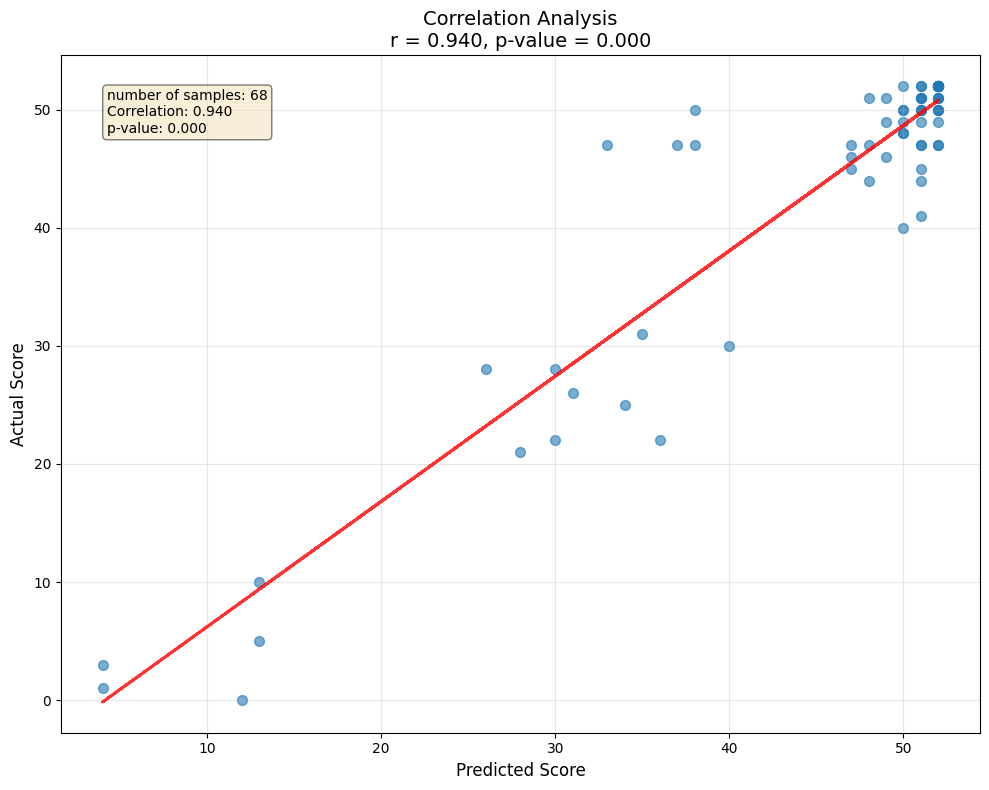

In [ ]:
create_correlation_plot(pre_np,ref_np,corr_,p_val)